---
title: "The Condorcet Jury Theorem and Democratic Rationality"
subtitle: "Sensitivity Analysis of Failure Conditions"
categories: ["theory", "simulation", "causal inference", "sensitivity analysis"]
keep-ipynb: true
self-contained: true
draft: true
toc: true
execute: 
  freeze: auto 
  execute: true
  eval: true
jupyter: applied-bayesian-regression-modeling-env
image: 'Independent_voter_errors_correlation.png'
author:
    - url: https://nathanielf.github.io/
    - affiliation: PyMC dev
citation: true
---


# The Legibility Trap: Contemptible Familiarity

Decision making in the modern corporation faces a paradox. On the surface, a smooth-running machine optimized for predictable outcomes. In practice, a careful balance between genuine risk assessment and the familiar processes that make investors feel confident and executives feel in control. But when familiar process becomes sacred process, something breaks: reasonable bets give way to bankable certainty, and accountability dissolves into alignment.

To the investment analyst and the private equity partner, "unfamiliarity" is unquantifiable risk. They demand a recognizable org chart, a standardized "Agile" workflow, and a set of "Core Values" that could be swapped between a pet-food startup and a sovereign wealth fund without anyone noticing. __This is the cult of Legibility__. Borrowing from James C. Scott’s _Seeing Like a State_, we see that when central authorities cannot understand a complex, organic system, they flatten it. They replace the wild, high-information "forest" of human talent with a "plantation" of identical, predictable units.

When you optimize primarily for the gaze of the outsider or conformity with precedent, you risk dulling your workforce's most valuable asset: their ability to see things differently. In our quest for "alignment" and adherence to legible standards, we can inadvertently destroy the only thing that makes a group smarter than an individual: _the generative friction of our differences._

What makes this pattern so difficult to resist is that it isn't purely imposed from above. We participate willingly; it is what Thi Nguyen calls "Value Capture". In the rough ground of reality it's genuinely hard to gauge quality, but in the planned organization we have metrics: 'Alignment,' 'Velocity,' and 'Team Spirit'. We trade the rich but murky value of truth-seeking for the thin but legible value of metric-meeting. We do so eagerly—not because we're foolish, but because legibility confers real benefits: clearer communication, easier justification, visible contribution. We adopt the value of the corporation as our own, and so short-circuit collective learning. 

But "miracle" of collective intelligence is a generative process that requires diversity. It requires that we be wrong in different directions so that, in the aggregate, we might be right. By smoothing out the "noise" of individual culture and opinion, we break the statistical engine that makes democracy and decentralization work. We break the statistical engine of collective intelligence: The Condorcet Jury Theorem.


## Do as I say, Not what I do.

Investors are among the world's most fervent believers in the power of diversification. They know that to survive a volatile market, they must hedge their bets across uncorrelated assets. Yet while the investor hedges in the aggregate, they need each subordinate company to appear as a single, comparable unit on a spreadsheet. They abstract away the details of any individual firm, eliminating the local variance in their portfolio view. They want each firm to be "aligned," "standardized," and "legible." In doing so, they incentivise a surface homogeneity that can propagate inward. The firms in their portfolio stop asking, 'Is this the right decision?' and start asking, 'Does this decision look aligned to the investor's model?' or "Are our peers doing the same?" The macro consequences of such mimicry are still being felt today, many years after the financial crisis of 2008.

The Condorcet Jury Theorem (CJT) is the mathematical foundation of this drive for diversification. It shows that if you have a group of independent actors who are minimally competent (i.e. $p > 0.5$ of being correct on binary decisions), then the probability of the majority being correct approaches 100% as the group size grows. There is real value in diversity when deployed well. But it's brittle, and many corporate "best practices"—however well-intentioned—can inadvertently undermine it.

::: {.callout-important}
## Deconstructing the Organizational Short-Circuit

In this post, we move beyond the idealized "spreadsheet" view of decision-making to understand why modern organizations often fail in lockstep. We will:

* **Revisit the Condorcet Miracle**: Define the mathematical preconditions for collective intelligence and identify where corporate "best practices" begin to subvert them.
* **Simulate Institutional Gravity**: Use a hierarchical Bayesian model to isolate how individual skill, systemic case difficulty, and organizational "blocks" compete for influence over the final vote.
* **Run the Post-Mortem**: Use Posterior Predictive Checks (PPC) to visualize how standardized cultures create an "accuracy ceiling" that remains stagnant even as the group size grows.
* **Bridge Theory to Philosophy**: Connect the statistical reality of correlated error to **James C. Scott’s** "Legibility" and **C. Thi Nguyen’s** "Value Capture".
:::

#### Setup

To understand how legibility short-circuits learning, we need a way to build a "company" from the ground up and stress-test its decision-making. Our simulation function, `simulate_jury_data`, is the generative heart of this piece. It doesn’t just create random numbers; it creates a world where we can toggle the parameters of Generative Friction.


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
from pytensor.tensor import gammaln

np.random.seed(42)

# Configuration
N_CASES = 50
N_JURORS = 15
JURY_SIZES = [3, 5, 7, 10, 15]
BLOCK_ID = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])
N_BLOCKS = 3

### Data Generation and the Ground Truth

In a healthy system, learning happens in the gaps between different perspectives. But in a "legible" system, those gaps are closed. Our simulation allows us to model this across three dimensions


In [2]:
def simulate_jury_data(n_cases, n_jurors, true_p=0.65, true_discrimination=0.5, 
                       block_id=None, true_sigma_block=1.2):
    """
    Simulate jury voting data with optional block effects.
    
    Parameters:
    -----------
    n_cases : int
        Number of cases to judge
    n_jurors : int
        Number of jurors
    true_p : float
        Average competence (probability of correct vote)
    true_discrimination : float
        Standard deviation of competence in logit space
    block_id : array, optional
        Group membership for each juror (enables faction effects)
    true_sigma_block : float
        Standard deviation of block effects
        
    Returns:
    --------
    votes : (n_cases, n_jurors) array
        Binary voting matrix
    p_jurors : (n_jurors,) array
        True competence of each juror
    true_states : (n_cases,) array
        Ground truth for each case
    """
    true_states = np.random.binomial(1, 0.5, n_cases)
    
    # Simulate heterogeneous competencies in logit space
    logit_p_jurors = np.random.normal(
        np.log(true_p / (1 - true_p)), 
        true_discrimination, 
        n_jurors
    )
    
    # Add block effects if specified
    if block_id is not None:
        n_blocks = len(np.unique(block_id))
        block_effect = np.random.normal(1, true_sigma_block, n_blocks)
        logit_p_jurors += block_effect[block_id]
    
    p_jurors = 1 / (1 + np.exp(-logit_p_jurors))
    
    # Generate votes
    votes = np.zeros((n_cases, n_jurors))
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_jurors[j] if true_states[i] == 1 else 1 - p_jurors[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return votes, p_jurors, true_states

# Generate our first dataset: simple case without blocks
votes, p_jurors, true_states = simulate_jury_data(N_CASES, N_JURORS)

print(f"Data simulated: {N_CASES} cases, {N_JURORS} jurors")
print(f"True average competence: {p_jurors.mean():.3f}")
majority = (votes.mean(axis=1) > 0.5) 
print(f"Majority vote accuracy: {np.mean(majority == true_states):.3f}")

Data simulated: 50 cases, 15 jurors
True average competence: 0.633
Majority vote accuracy: 0.840


Here how our data generating process encodes a baseline degree of juror competence. On any yes/no question we've ensured that the average juror has $(p \sim N(.65, \sigma_{disc}))$ chance of getting the right answer. The $\sigma_{disc}$ determines the range of individual skill in the population. We've then asked each juror to cast their vote on 50 decisions.

## Sensitivity to Prior Beliefs About Competence

In this model, we treat every employee as an interchangeable unit. We assume there are no factions, no "weird" outliers, and no cases that are harder than others. More important than that is the key is the requirement of conditional independence. No two people are "thinking alike" because of their shared training or culture; they are only "aligned" because they are all seeing the same Truth. This model (Model 1) defines the idealized world of the Condorcet Jury Theorem. Our first sensitivity analysis asks: **how much do our conclusions depend on our prior beliefs about juror competence?** 


In [3]:
# Define prior specifications
prior_specs = {
    'weakly_informative': {
        'alpha': 3, 'beta': 2, 
        'desc': 'Weakly informative (centered at 0.6)'
    },
    'strong_competence': {
        'alpha': 10, 'beta': 3, 
        'desc': 'Strong prior (p ~ 0.76)'
    },
    'barely_competent': {
        'alpha': 6, 'beta': 5, 
        'desc': 'Skeptical prior (p ~ 0.55)'
    },
    'incompetent': {
        'alpha': 5, 'beta': 10, 
        'desc': 'Incompetent prior (p ~ 0.33)'
    },
}

To perform our sensitivity analysis, we test four different "Corporate Climates." These represent the level of faith an organization has in its own internal competence. When a corporate decision leads to disaster, the post-mortem almost always focuses on competence. The diagnosis is usually that the "wrong people were in the room" or that the team lacked "domain expertise." This focus on individual skill is a convenient fiction for the investor class; it suggests that the organizational structure is fine, it just needs better "units."

We'll see that there are legitimate reasons to worry about individual incompetence for collective decision making. But you need to achieve a critical mass of incompetence for consequential error. In most cases marginal incomptence within an organisation rarely breaks the corporate mechanism. As long as those errors are independent—as long as the "incompetent" people are failing in their own unique, "weird" ways—the majority will still find the truth. The high-performers provide the signal, and the low-performers provide "white noise" that cancels itself out.

### Model 1: The Classical Condorcet Jury Model

Let $T_i \in \{0,1\}$ denote the true state of case $i = 1,\dots,N$, with
$$
T_i \sim \text{Bernoulli}(0.5).
$$

Each juror $j = 1,\dots,J$ casts a binary vote $V_{ij} \in \{0,1\}$.
Conditioned on the truth, all jurors share a common probability of voting correctly:
$$
\Pr(V_{ij} = T_i \mid p) = p, \qquad p > \tfrac{1}{2}.
$$

Equivalently, the likelihood may be written as:
$$
V_{ij} \mid T_i, p \sim
\begin{cases}
\text{Bernoulli}(p) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p) & \text{if } T_i = 0.
\end{cases}
$$

This model imposes three strong assumptions:

1. **Exchangeability across jurors**: all jurors are equally competent.
2. **Exchangeability across cases**: all cases are equally difficult.
3. **Conditional independence**:
$$
V_{ij} \perp V_{ik} \mid T_i, p.
$$

These assumptions define the idealized world in which the Condorcet Jury Theorem applies.


In [4]:
def fit_base_condorcet_model(votes, prior_spec, n_cases=N_CASES):
    """
    Fit basic Condorcet model with specified prior on competence.
    
    This model assumes:
    - All jurors have identical competence p
    - Votes are conditionally independent given the truth
    - Equal prior probability for guilty/not guilty
    """
    with pm.Model() as model:
        # SENSITIVITY PARAMETER: Prior on competence
        p = pm.Beta('p', alpha=prior_spec['alpha'], beta=prior_spec['beta'])
        
        # Latent true state of each case
        true_state = pm.Bernoulli('true_state', p=0.5, shape=n_cases)
        
        # Voting probability depends on true state
        vote_prob = pm.Deterministic('vote_prob', pm.math.switch(
            pm.math.eq(true_state[:, None], 1), p, 1 - p
        ))
        
        pm.Bernoulli('votes', p=vote_prob, observed=votes)
        
        # Posterior predictive: majority vote accuracy for different jury sizes
        for size in [3, 7, 15]:
            votes_sim = pm.Bernoulli(f'sim_votes_{size}', p=p, shape=size)
            pm.Deterministic(
                f'majority_correct_{size}',
                pm.math.sum(votes_sim) > size / 2
            )
        
        # Sample
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(2000, tune=1000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model

The key property of the model we want to probe is how the accuracy of the majority vote evolves as we incorporate more jurors in the vote. The stressor we apply to test the system is to gauge how this accuracy evolve with degrees of population competence.
$$
p \sim \text{Beta}(\alpha, \beta).
$$

No assumptions about independence or exchangeability are altered. Instead, this model makes explicit the epistemic commitment that the Condorcet theorem leaves implicit: jurors are often assumed to be better than random *a priori*. You must hire well so that the average for each employee has a better than coin-flip chance of accuracy. This modest requirement is all we require to ensure collective accuracy, under the conditions of the model. 


In [5]:
# | output: false
# Fit under all prior specifications
traces = {}
for prior_name, spec in prior_specs.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_base_condorcet_model(votes, spec)
    traces[prior_name] = idata
    traces[prior_name + '_model'] = model


Fitting with Weakly informative (centered at 0.6)...


Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Strong prior (p ~ 0.76)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Skeptical prior (p ~ 0.55)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Sampling: [p, sim_votes_15, sim_votes_3, sim_votes_7, true_state, votes]



Fitting with Incompetent prior (p ~ 0.33)...


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [p]


>BinaryGibbsMetropolis: [true_state, sim_votes_3, sim_votes_7, sim_votes_15]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [votes]


Output()

Let's examine how our prior beliefs influence prediction. We have sampled the majority votes under both our prior and the derived posterior distribution. We see how the accuracy of the majority vote grows with more voters when the priors about group competence is high. 


In [6]:
def extract_estimates(traces, prior_specs, jury_sizes=[3, 7, 15], stage='prior'):
    """Extract majority accuracy estimates from traces."""
    ests = {}
    for prior_name in prior_specs.keys():
        estimates = []
        for size in jury_sizes:
            p = traces[prior_name][stage][f'majority_correct_{size}'].mean().item()
            estimates.append(p)
        ests[prior_name] = estimates
    
    return pd.DataFrame(
        ests, 
        index=[f'Correct % for Majority of {s}' for s in jury_sizes]
    )

# Compare prior and posterior estimates
prior_estimates = extract_estimates(traces, prior_specs, stage='prior')
posterior_estimates = extract_estimates(traces, prior_specs, stage='posterior')

print("\n" + "="*70)
print("PRIOR ESTIMATES")
print("="*70)
print(prior_estimates)

print("\n" + "="*70)
print("POSTERIOR ESTIMATES (AFTER SEEING DATA)")
print("="*70)
print(posterior_estimates)


PRIOR ESTIMATES
                              weakly_informative  strong_competence  \
Correct % for Majority of 3                0.616              0.838   
Correct % for Majority of 7                0.672              0.912   
Correct % for Majority of 15               0.656              0.944   

                              barely_competent  incompetent  
Correct % for Majority of 3              0.574        0.288  
Correct % for Majority of 7              0.594        0.206  
Correct % for Majority of 15             0.610        0.158  

POSTERIOR ESTIMATES (AFTER SEEING DATA)
                              weakly_informative  strong_competence  \
Correct % for Majority of 3               0.5380           0.620250   
Correct % for Majority of 7               0.5485           0.667125   
Correct % for Majority of 15              0.5620           0.727750   

                              barely_competent  incompetent  
Correct % for Majority of 3           0.475250     0.381875  


However, we can also see how the aggregation of incompetent opinion tends towards incorrect. 


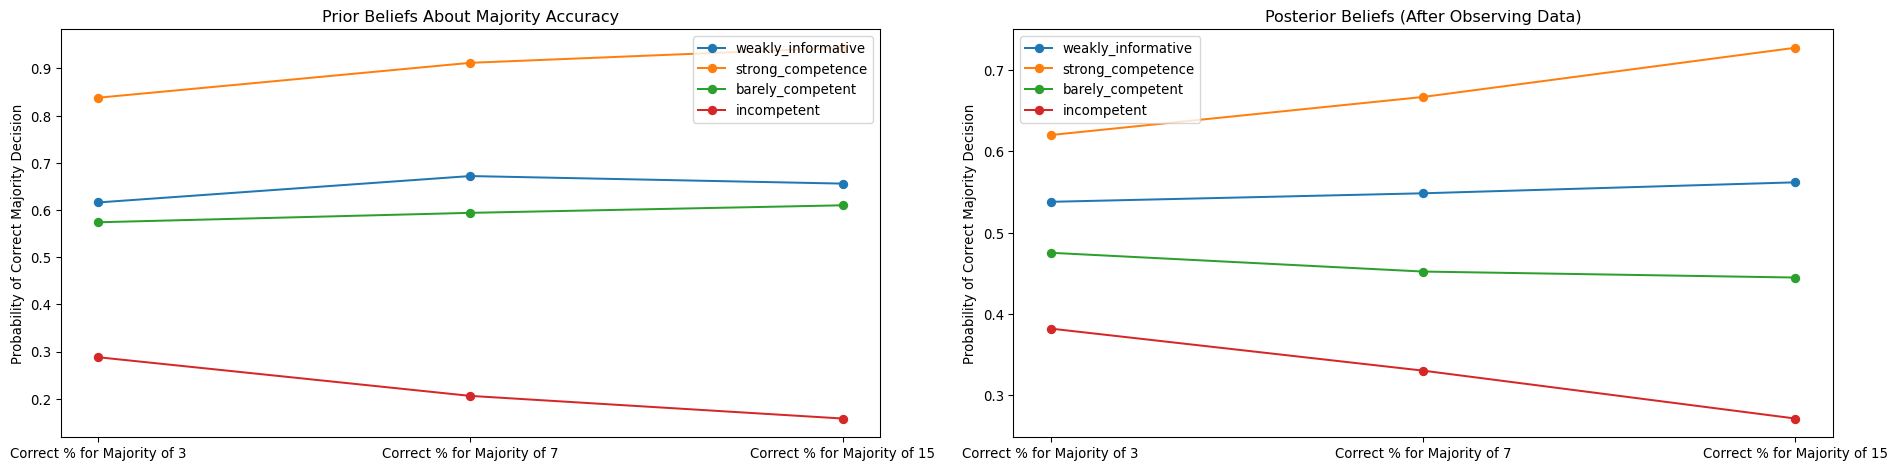

In [7]:
# Visualize the shift from prior to posterior
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for prior_name in prior_specs.keys():
    axs[0].plot(prior_estimates.index, prior_estimates[prior_name], 
                label=prior_name, marker='o')
    axs[1].plot(posterior_estimates.index, posterior_estimates[prior_name], 
                label=prior_name, marker='o')

axs[0].legend()
axs[1].legend()
axs[0].set_title("Prior Beliefs About Majority Accuracy")
axs[1].set_title("Posterior Beliefs (After Observing Data)")
axs[0].set_ylabel("Probability of Correct Majority Decision")
axs[1].set_ylabel("Probability of Correct Majority Decision")

plt.tight_layout()
plt.show()

You cannot avoid the requirement of minimum competence in the jury pool if you hope for collective wisdom. But more strikingly, when we have even modest competence, the aggregation of votes quickly converges towards high accuracy. This is exactly the finding of Condorcet's Jury Theorem. 

::: {.callout-important}
## Formal Statement: The Condorcet Jury Theorem

Let a group of $n$ independent individuals (a "jury") be tasked with choosing between two outcomes, one of which is "correct." Let $p$ represent the probability of any single individual making the correct choice. The theorem consists of two parts:

1.  **The Competence Requirement:** If $p > 0.5$, then the probability that a majority of the group makes the correct choice is greater than $p$.
2.  **The Asymptotic Result:** As $n \to \infty$, the probability that the majority choice is correct approaches $1$.

Conversely, if $p < 0.5$, increasing the size of the jury only increases the probability that the group will arrive at the *wrong* conclusion, with that probability approaching $1$ as $n$ grows.

This is a theorem. We're not showing that it is incorrect, but we are stress-testing it in finite domains to gauge it's applicability to practical decision making. 
:::

This mathematical law is the 'efficiency' that the investor class is buying. You might look at this theorem and see a guarantee: as long as we hire 'competent' people ($p > 0.5$) and align them, we can't lose. But the theorem has a hidden poison pill. It relies entirely on independent errors, and we know that competence isn't uniform. This pulls us in two ways: (1) management panic over hiring standards and (2) fostering diversity in the employee base. We'll look at (1) next. 

## Individual Differences in Competence

The base Condorcet model assumes all jurors are identically competent. In reality, people vary in expertise, attention, and judgment. Let's model **heterogeneity** in juror competence. To gauge these effects we'll use a hierarchical model where individual competencies are drawn from a population distribution. The key sensitivity parameter is $\sigma$ (discrimination): how much do jurors differ?

#### Heterogeneous Juror Competence

We now relax the assumption that all jurors are equally competent. Each juror $j$ is assigned an individual probability of voting correctly:
$$
\text{logit}(p_j) = \mu + \sigma z_j, \qquad z_j \sim \mathcal{N}(0,1).
$$


For a fixed juror $j$, define the number of agreements with the majority:
$$
A_j = \sum_{i=1}^N \mathbb{1}\{V_{ij} = \text{majority}_i\}.
$$

Under the assumption that cases are exchangeable and votes are conditionally independent given $p_j$, we obtain the exact likelihood:

$$
A_j \mid p_j \sim \text{Binomial}(N, p_j).
$$

This is not an approximation. It is the marginal likelihood obtained by integrating over $$N$$ independent Bernoulli trials:
$$
\prod_{i=1}^N \text{Bernoulli}(V_{ij} \mid p_j)
\;\Longrightarrow\;
\text{Binomial}(A_j \mid N, p_j).
$$

This observation motivates a re-articuation of the condorcet model. The binomial phrasing is often easier to sample than the Bernoulli likelihood, so we shall switch to that model. Our next model uses a Binomial likelihood and  relies on two assumptions. We hold fixed the exchangeability across the cases and we rely on sufficiency of the count statistic. Once jurors are treated as stable measurement instruments, their entire voting history becomes a single aggregated observation. 

### Model 2: Varying Competence


In [8]:
def fit_hierarchical_model(votes, n_jurors, discrimination_prior):
    """
    Fit hierarchical model with individual variation in competence.
    
    Model structure:
    - μ: population mean competence (in logit space)
    - σ: population standard deviation (SENSITIVITY PARAMETER)
    - Each juror has individual competence drawn from N(μ, σ)
    
    We use non-centered parameterization for better sampling.
    """
    majority_votes = (votes.mean(axis=1) > 0.5).astype(int)
    agreements_per_juror = np.array([
        (votes[:, j] == majority_votes).sum() for j in range(n_jurors)
    ])
    
    with pm.Model() as model:
        # Population-level parameters
        mu_logit_p = pm.Normal('mu_logit_p', mu=0.6, sigma=0.5)
        
        # KEY SENSITIVITY PARAMETER: individual discrimination
        sigma_logit_p = pm.HalfNormal(
            'sigma_logit_p', 
            sigma=discrimination_prior['sigma']
        )
        
        # Non-centered parameterization: logit_p = μ + σ * z
        z_juror = pm.Normal('z_juror', mu=0, sigma=1, shape=n_jurors)
        logit_p_juror = pm.Deterministic(
            'logit_p_juror', 
            mu_logit_p + sigma_logit_p * z_juror
        )
        p_juror = pm.Deterministic('p_juror', pm.math.invlogit(logit_p_juror))
        
        # Collapsed likelihood: count agreements with majority
        pm.Binomial('agreements', n=N_CASES, p=p_juror, 
                   observed=agreements_per_juror)
        
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(1000, tune=2000, random_seed=42,
                              target_accept=0.95, return_inferencedata=True,
                              idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    
    return idata, model


Again, we'll test a range of priors. But this time we'll push on the range of permissable competence in the jury pool. 


In [9]:
# | output: false

# Test three levels of discrimination
discrimination_priors = {
    'weak_discrimination': {
        'sigma': 0.5, 
        'desc': 'Weak discrimination (σ ~ 0.5)'
    },
    'moderate_discrimination': {
        'sigma': 1.0, 
        'desc': 'Moderate discrimination (σ ~ 1)'
    },
    'strong_discrimination': {
        'sigma': 2.0, 
        'desc': 'Strong discrimination (σ ~ 2)'
    },
}

traces_discrimination = {}
for prior_name, spec in discrimination_priors.items():
    print(f"\nFitting with {spec['desc']}...")
    idata, model = fit_hierarchical_model(votes, N_JURORS, spec)
    traces_discrimination[prior_name] = idata
    traces_discrimination[prior_name + '_model'] = model

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Weak discrimination (σ ~ 0.5)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]


Initializing NUTS using jitter+adapt_diag...



Fitting with Moderate discrimination (σ ~ 1)...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Sampling: [agreements, mu_logit_p, sigma_logit_p, z_juror]



Fitting with Strong discrimination (σ ~ 2)...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mu_logit_p, sigma_logit_p, z_juror]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Sampling: [agreements]


Output()

Whereas in the previous model we observed each and every vote in the likelihood, here we're abstracting away from the particular and assuming their realised values are a consequece of latent structure; individual estimable competence. 


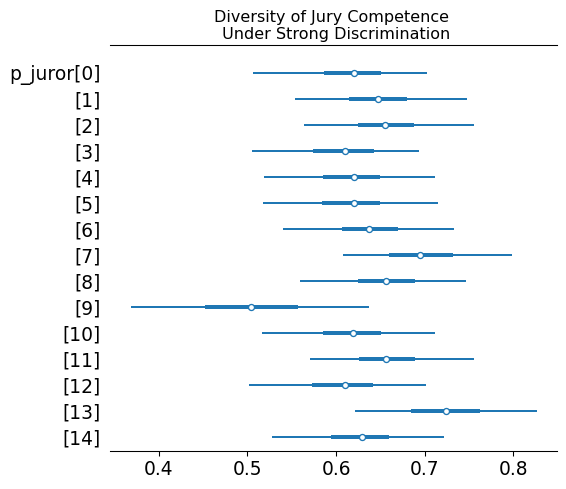

In [10]:
# Examine one of the fitted models
ax = az.plot_forest(traces_discrimination['strong_discrimination'], var_names=['p_juror'], combined=True)
ax[0].set_title("Diversity of Jury Competence \n Under Strong Discrimination");

By collapsing these observations into a Binomial distribution, we focus the model’s attention on the success rate of the collective. Paradoxically, by "throwing away" the individual case observations of the jurors, we force the model to account for the variance in the process itself.

### The Generative Process and Implied Votes 

It's for this reason we now rely on Posterior Predictive Sampling (PPC) to reconstruct these votes is that we are no longer just fitting a line to a set of points; we are simulating a generative process. To understand the implications of different discrimination levels, we need to simulate complete jury deliberations. In other words, we need to translate our individual voter's profile into votes. 
$$
V_{ij} \mid T_i, p_j \sim
\begin{cases}
\text{Bernoulli}(p_j) & \text{if } T_i = 1, \\
\text{Bernoulli}(1-p_j) & \text{if } T_i = 0.
\end{cases}
$$

This will then allow us to test for accuracy of the majority under different ranges of skill. The core insight is that we must forward sample to derive the voting profile of each individual.


In [11]:
def simulate_votes_from_competence(p_juror, n_cases, truth=None):
    """Generate votes given juror competencies and ground truth."""
    n_jurors = len(p_juror)
    if truth is None:
        truth = np.random.binomial(1, 0.5, size=n_cases)
    
    votes = np.zeros((n_cases, n_jurors), dtype=int)
    for i in range(n_cases):
        for j in range(n_jurors):
            prob = p_juror[j] if truth[i] == 1 else 1 - p_juror[j]
            votes[i, j] = np.random.binomial(1, prob)
    
    return truth, votes


To do so we'll define a number of helper functions below.


In [12]:
# | code-fold: true

def compute_diagnostics(votes, truth):
    """Compute suite of diagnostic metrics for jury performance."""
    majority = votes.mean(axis=1) > 0.5
    
    diagnostics = {
        'majority_accuracy': np.mean(majority == truth),
        'unanimity_rate': np.mean(
            (votes.sum(axis=1) == 0) | (votes.sum(axis=1) == votes.shape[1])
        ),
        'juror_agreement': np.mean(votes == truth[:, None], axis=0),
    }
    
    # Error correlation: do jurors make mistakes together?
    errors = votes != truth[:, None]
    if errors.var(axis=0).sum() > 0:
        diagnostics['error_corr'] = np.corrcoef(errors.T)
    else:
        diagnostics['error_corr'] = np.zeros((votes.shape[1], votes.shape[1]))
    
    return diagnostics


def majority_accuracy_by_size(votes, truth, jury_size):
    """Calculate accuracy for random sub-juries of given size."""
    n_cases, n_jurors = votes.shape
    correct = np.zeros(n_cases, dtype=int)
    
    for i in range(n_cases):
        jurors = np.random.choice(n_jurors, size=jury_size, replace=False)
        majority = votes[i, jurors].mean() > 0.5
        correct[i] = (majority == truth[i])
    
    return correct.mean()


def run_ppc_analysis(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Run comprehensive posterior predictive checks."""
    p_juror_samples = (idata.posterior['p_juror']
                      .stack(sample=("chain", "draw")).values)
    n_jurors, n_samples = p_juror_samples.shape
    
    results = {
        'majority_acc': np.zeros(n_samples),
        'unanimity': np.zeros(n_samples),
        'error_corr': np.zeros((n_samples, n_jurors, n_jurors)),
        'accuracy_by_size': {k: np.zeros(n_samples) for k in jury_sizes}
    }
    
    for s in range(n_samples):
        _, votes = simulate_votes_from_competence(
            p_juror_samples[:, s], n_cases, truth
        )
        diag = compute_diagnostics(votes, truth)
        
        results['majority_acc'][s] = diag['majority_accuracy']
        results['unanimity'][s] = diag['unanimity_rate']
        results['error_corr'][s] = diag['error_corr']
        
        for k in jury_sizes:
            results['accuracy_by_size'][k][s] = (
                majority_accuracy_by_size(votes, truth, k)
            )
    
    return results


def summarize_ppc(ppc_results, jury_sizes=JURY_SIZES):
    """Create summary DataFrame from PPC results."""
    percentiles = [5, 50, 95]
    summaries = []
    
    for k in jury_sizes:
        summaries.append(np.percentile(
            ppc_results['accuracy_by_size'][k], percentiles
        ))
    
    df = pd.DataFrame(summaries).T
    df.columns = [f'majority_accuracy_{k}' for k in jury_sizes]
    df.index = [f'percentile_{p}' for p in percentiles]
    
    return df


def compare_prior_posterior(idata, n_cases, truth, jury_sizes=JURY_SIZES):
    """Compare prior and posterior predictive distributions."""
    results = {}
    
    for stage in ['prior', 'posterior']:
        p_samples = (getattr(idata, stage)['p_juror']
                    .stack(sample=("chain", "draw")).values)
        n_jurors, n_samples = p_samples.shape
        
        # Simplified PPC for comparison
        stage_results = {k: np.zeros(n_samples) for k in jury_sizes}
        for s in range(n_samples):
            _, votes = simulate_votes_from_competence(
                p_samples[:, s], n_cases, truth
            )
            for k in jury_sizes:
                stage_results[k][s] = majority_accuracy_by_size(votes, truth, k)
        
        results[stage] = summarize_ppc({'accuracy_by_size': stage_results}, 
                                      jury_sizes)
    
    return pd.concat(results, names=['stage', 'percentile'])

def plot_prior_posterior_comparison(df, title="Majority Accuracy"):
    """Plot prior vs posterior distributions."""
    x_values = JURY_SIZES
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for stage, color in [('prior', 'blue'), ('posterior', 'red')]:
        median = df.loc[(stage, 'percentile_50')]
        low = df.loc[(stage, 'percentile_5')]
        high = df.loc[(stage, 'percentile_95')]
        
        ax.plot(x_values, median, label=f'{stage.title()} Median', 
                color=color, marker='o')
        ax.fill_between(x_values, low, high, color=color, alpha=0.2,
                       label=f'{stage.title()} (5th-95th)')
    
    ax.set_title(title)
    ax.set_xlabel('Number of Jurors')
    ax.set_ylabel('Majority Accuracy')
    ax.set_xticks(x_values)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig


Now let's apply this framework. We'll focus on the moderate discrimination case as it's most realistic:


In [13]:
# Analyze the moderate discrimination case
print(f"\n{'='*70}")
print(f"Analysis: {discrimination_priors['moderate_discrimination']['desc']}")
print('='*70)

comparison = compare_prior_posterior(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

comparison


Analysis: Moderate discrimination (σ ~ 1)


majority_accuracy_3  majority_accuracy_5  \
stage     percentile                                                
prior     percentile_5                  0.40                 0.38   
          percentile_50                 0.68                 0.72   
          percentile_95                 0.92                 0.96   
posterior percentile_5                  0.58                 0.62   
          percentile_50                 0.70                 0.74   
          percentile_95                 0.80                 0.84   

                         majority_accuracy_7  majority_accuracy_10  \
stage     percentile                                                 
prior     percentile_5                  0.36                 0.379   
          percentile_50                 0.76                 0.800   
          percentile_95                 0.98                 1.000   
posterior percentile_5                  0.66                 0.700   
          percentile_50                 0.78                 0.820   
          percentile_95                 0.88                 0.900   

                         majority_accuracy_15  
stage     percentile                           
prior     percentile_5                   0.26  
          percentile_50                  0.86  
          percentile_95                  1.00  
posterior percentile_5                   0.74  
          percentile_50                  0.86  
          percentile_95                  0.94

We still see convergen to the truth as we scale up the size of our majority even when we allow heterogeneous levels of skill in the voting population. The median prior and posterior estimates of accuracy are quite close, but we've significantly shrunk the uncertainty in our estimate. 


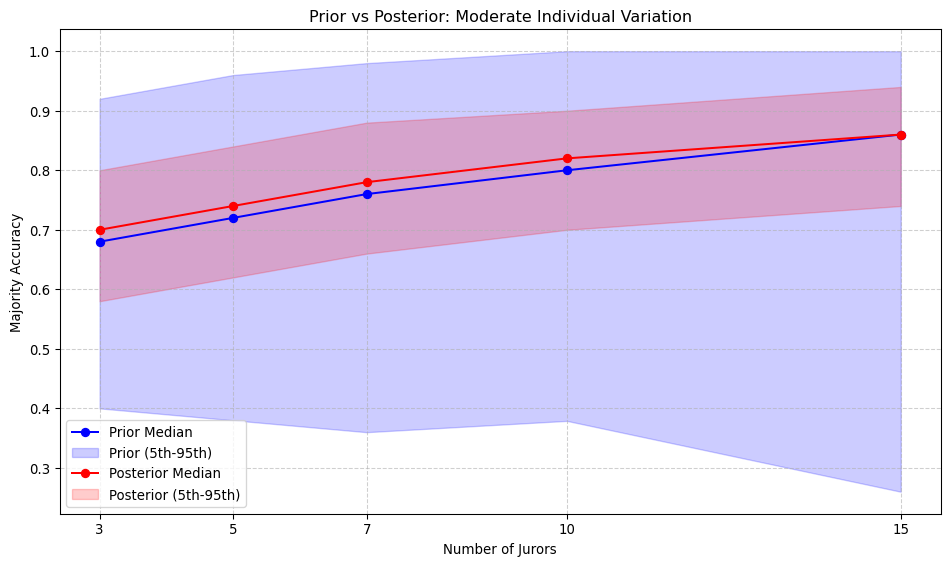

In [14]:
plot_prior_posterior_comparison(
    comparison, 
    title="Prior vs Posterior: Moderate Individual Variation"
);

The pattern is consistent across all discrimination levels: the data updates our beliefs, and larger juries show higher accuracy. The key question is whether errors remain independent.

#### Error Correlation Analysis

A critical assumption of Condorcet is **independence**: jurors make errors independently. Let's check this for our moderate discrimination model:


/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nathanielforde/mambaforge/envs/applied-bayesian-regression-modeling-env/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


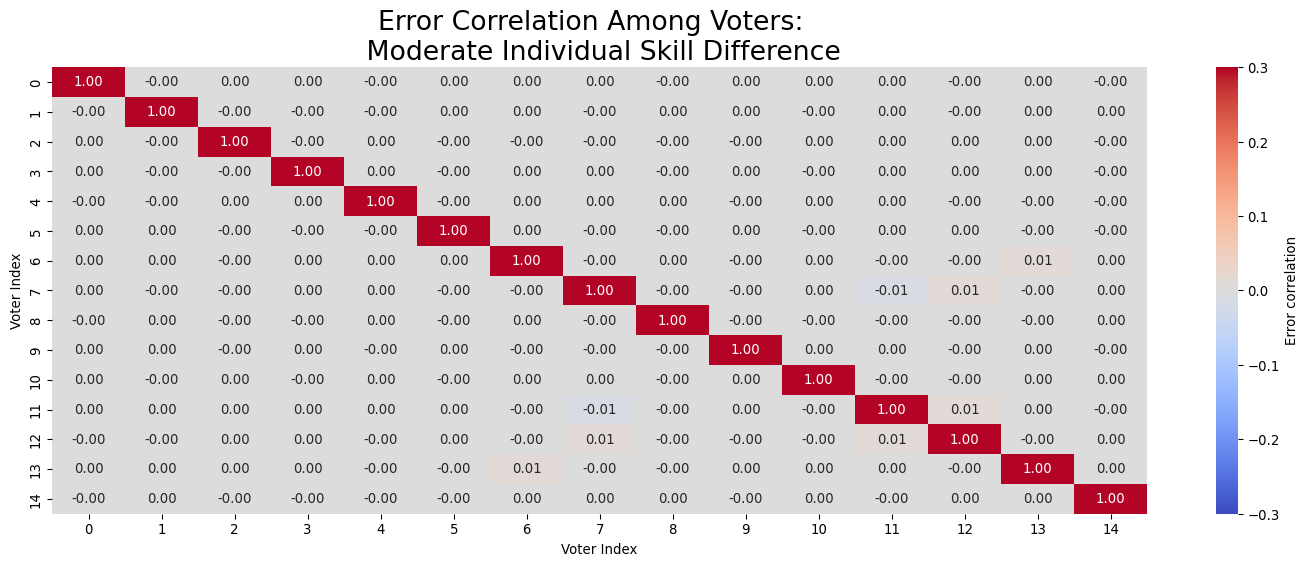

In [15]:
# | output: false
def plot_error_correlation_heatmap(ppc_results, title="Error Correlation"):
    """Plot mean error correlation matrix, handling NaN values properly."""
    all_corrs = ppc_results['error_corr']  # (n_samples, n_jurors, n_jurors)
    
    # Use nanmean to properly average across samples, ignoring NaNs
    mean_corr = np.nanmean(all_corrs, axis=0)
    
    # For cells that are still NaN (all samples were NaN), replace with 0
    mean_corr = np.nan_to_num(mean_corr, nan=0.0)
    mean_corr = np.round(mean_corr, 2)
    fig, ax = plt.subplots(figsize=(15, 6))
    sns.heatmap(mean_corr, vmin=-.3, vmax=.3, cmap="coolwarm",
                square=False, cbar_kws={"label": "Error correlation"}, ax=ax, 
                annot=True, fmt=".2f")
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Voter Index")
    ax.set_ylabel("Voter Index")
    plt.tight_layout()
    return fig


def summarize_error_correlation(ppc_results):
    """Extract summary statistics from error correlation matrices."""
    corr = ppc_results['error_corr']
    n = corr.shape[1]
    
    off_diag = []
    for s in range(corr.shape[0]):
        mat = corr[s]
        # Extract upper triangle (excluding diagonal)
        upper_tri = mat[np.triu_indices(n, k=1)]
        # Only include non-NaN values
        valid_values = upper_tri[~np.isnan(upper_tri)]
        if len(valid_values) > 0:
            off_diag.extend(valid_values)
    
    off_diag = np.array(off_diag)
    
    if len(off_diag) == 0:
        return {
            'mean_off_diag': np.nan,
            'sd_off_diag': np.nan,
            'p95_abs_corr': np.nan,
        }
    
    return {
        'mean_off_diag': off_diag.mean(),
        'sd_off_diag': off_diag.std(),
        'p95_abs_corr': np.percentile(np.abs(off_diag), 95),
    }


ppc_moderate = run_ppc_analysis(
    traces_discrimination['moderate_discrimination'], 
    N_CASES, 
    true_states
)

fig = plot_error_correlation_heatmap(
    ppc_moderate, 
    title="Error Correlation Among Voters:  \n Moderate Individual Skill Difference"
);
fig.savefig("Independent_voter_errors_correlation.png")

![](Independent_voter_errors_correlation.png)


In [16]:
print("\nError Correlation Summary:")
summarize_error_correlation(ppc_moderate)


Error Correlation Summary:


{'mean_off_diag': np.float64(4.1269912183272494e-05),
 'sd_off_diag': np.float64(0.14293965923889015),
 'p95_abs_corr': np.float64(0.2792611296287719)}

**Key insight**: With heterogeneous competence alone, errors remain largely uncorrelated. The Condorcet theorem's independence assumption holds—so far. Which is to say that diverse workforces and varying degrees of competence do not inherently short-circuit the firm's ability to learn. 

### From Aggregated to Generative: Why We Need Item Response Theory

The binomial model served us well for exploring individual differences because we only cared whether jurors *on average* agreed with majorities. But to explore **shared case difficulty**—where hard cases cause everyone to struggle simultaneously—we need to model each vote explicitly.

Enter Item Response Theory (IRT). Instead of collapsing votes into agreement counts, we now model:
$$V_{ij} \mid T_i, p_j, \delta_i$$

This lets us ask: when case *i* is hard (large |δ_i|), do errors cluster across jurors? The binomial model can't answer this because it averages over cases. The IRT model can, and the answer will show us where the Condorcet theorem truly breaks down.

## Shared Case Difficulty: When Everyone Fails Together
Now we introduce a critical violation: shared case-level effects. Some cases are genuinely harder, causing even competent jurors to fail together. This is the first structural break in the independence assumption—and it reveals why "hard problems" are exponentially harder for groups than the Condorcet theorem predicts.

### The Nature of Difficulty
In our models so far, we've assumed cases are exchangeable—each decision is equally difficult. But reality is messier. Consider:

- The obvious merger: Everyone agrees it's a good fit
- The ambiguous pivot: Market signals are mixed, competitive response is uncertain
- The moonshot bet: Technical feasibility is genuinely unknown

These aren't just decisions with different answers; they're decisions with different signal strength. When the signal is weak—when δᵢ is large in magnitude—even highly competent decision-makers will struggle. More importantly, they'll struggle in the same direction. This is fundamentally different from the heterogeneous competence we modeled earlier. Individual skill differences create uncorrelated noise: some people excel where others fail, and in aggregate, errors cancel out. Case difficulty creates correlated signal loss: when the evidence is weak, everyone's instruments fail simultaneously.

### Simulating Shared Case Shocks and Heterogenous Skills
To properly explore this, we need to do posterior predictive sampling that includes case difficulty in the generative model. We can't just fit a model with case effects and examine the posterior—we need to generate new votes under different difficulty regimes and see how the correlation structure changes.


In [17]:
# ============================================================================
# PART 1: DATA GENERATION
# ============================================================================

import numpy as np

def simulate_irt_data(
    n_cases, n_jurors,
    true_mu_theta=0.5,          # Baseline competence (>0 => above chance)
    true_sigma_theta=1.0,       # Individual skill variance
    true_sigma_delta=0.5,       # Case difficulty variance
    block_id=None,              # Integer block index per juror
    block_type="expertise",     # "expertise" | "groupthink" | "mixed"
    true_sigma_block=0.5,       # Block mean competence SD
    true_kappa_groupthink=0.5,  # Skill compression (<1)
    true_kappa_expertise=1.2,   # Skill amplification (>1)
    treatment=None,             # Per-juror treatment indicator
    true_tau=0.8,               # Treatment effect on ability
    seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # ------------------------------------------------------------------
    # Ground truth states for cases
    # ------------------------------------------------------------------
    true_states = np.random.binomial(1, 0.5, n_cases)

    # ------------------------------------------------------------------
    # Baseline juror abilities
    # ------------------------------------------------------------------
    theta_raw = np.random.normal(true_mu_theta, true_sigma_theta, n_jurors)
    theta = theta_raw.copy()

    # ------------------------------------------------------------------
    # Case difficulties
    # ------------------------------------------------------------------
    delta = np.random.normal(0, true_sigma_delta, n_cases)
    print("Generated IRT Data:")

    # ------------------------------------------------------------------
    # Block-level social mechanisms
    # ------------------------------------------------------------------
    if block_id is not None:
        block_id = np.asarray(block_id)
        block_ids = np.unique(block_id)
        n_blocks = len(block_ids)

        # Mean competence shifts per block
        u_block = np.random.normal(0, true_sigma_block, n_blocks)

        # Skill expression scaling
        if block_type == "expertise":
            kappa = np.full(n_blocks, true_kappa_expertise)
        elif block_type == "groupthink":
            kappa = np.full(n_blocks, true_kappa_groupthink)
        elif block_type == "mixed":
            kappa = np.random.choice(
                [true_kappa_expertise, true_kappa_groupthink],
                size=n_blocks
            )
        else:
            raise ValueError("block_type must be 'expertise', 'groupthink', or 'mixed'")

        # Apply block effects
        for b in block_ids:
            idx = block_id == b
            theta[idx] = (
                true_mu_theta
                + u_block[b]
                + kappa[b] * (theta_raw[idx] - true_mu_theta)
            )
        print(f"  Block type: {block_type}")

    # ------------------------------------------------------------------
    # Treatment effect (additive, separable)
    # ------------------------------------------------------------------
    if treatment is not None:
        theta = theta + true_tau * treatment

    # ------------------------------------------------------------------
    # Voting process
    # ------------------------------------------------------------------
    votes = np.zeros((n_cases, n_jurors), dtype=int)

    for i in range(n_cases):
        # Rasch model: logit(p_correct) = ability - difficulty
        logit_p_correct = theta - delta[i]
        p_correct = 1 / (1 + np.exp(-logit_p_correct))

        for j in range(n_jurors):
            if true_states[i] == 1:
                votes[i, j] = np.random.binomial(1, p_correct[j])
            else:
                votes[i, j] = np.random.binomial(1, 1 - p_correct[j])

    # ------------------------------------------------------------------
    # Diagnostic majority accuracy
    # ------------------------------------------------------------------
    majority = (votes.mean(axis=1) > 0.5).astype(int)
    accuracy = np.mean(majority == true_states)

    print(f"  Majority accuracy: {accuracy:.3f}")

    return votes, theta, delta, true_states


Now we generate three varieties of voting data where the drivers of voting outcomes are more or less variously effected by: individual competence, case difficulty, effects of block voting. 


In [18]:
# Configuration
N_CASES = 50
N_JURORS = 30
np.random.seed(100)
BLOCK_ID = np.random.choice([1, 0, 2], size=N_JURORS)
JURY_SIZES = [3, 5, 7, 10, 15, 20, 30]

votes_vanilla, t_theta, t_delta, truth_vanilla = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=0.8,
    true_sigma_delta=0.5,
    seed=42
)
    

votes_blocked, t_theta_blocked, t_delta_blocked, truth_blocked = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=0.1,
    true_sigma_delta=3,
    block_id=BLOCK_ID,
    true_sigma_block=10,
    block_type="groupthink",  
    seed=43
)

treatment = np.random.binomial(1, .5, size=N_JURORS)

votes_full, t_theta_full, t_delta_full, truth_full = simulate_irt_data(
    N_CASES, N_JURORS,
    true_sigma_theta=0.1,
    true_sigma_delta=6,
    block_id=BLOCK_ID,
    true_sigma_block=10,
    treatment=treatment,
    block_type="expertise",  
    true_tau=0.3, # random variation across voters
    seed=44
)


Generated IRT Data:
  Majority accuracy: 0.800
Generated IRT Data:
  Block type: groupthink
  Majority accuracy: 0.620
Generated IRT Data:
  Block type: expertise
  Majority accuracy: 0.720


This should highlight the diversity of factors that contribute to individual accuracy, but more importantly how the aggregation of opinion determines the success or failure of organisational decisions. Crucially, we've operationalised the effects of value capture by allowing for block-voting effects. Note however, the block effects can be both positive and negative; reflecting either shared error or expertise. 

## Voting Blocks and Improvement Programmes

There is a tension between the forces that will determine whether an organization can sustain collective wisdom or succumbs to coordinated failure: block effects ($\beta$) and treatment programmes ($\tau$). These structural additions represent opposing gravitational forces in a delicate equilibrium. Pull too hard in one direction and you get chaos; pull too hard in the other and you get lockstep failure.

### The Mathematical Structure: Competing Forces

We model each juror's vote as a negotiation between three forces:

$$
\text{logit}\,\Pr(V_{ij} = T_i) = \underbrace{\alpha_j}_{\text{individual skill}} + \underbrace{\beta_{b(j)}}_{\text{block gravity}} + \underbrace{\delta_i}_{\text{case difficulty}} - \underbrace{\tau_j \cdot Z_j}_{\text{treatment push}}
$$

Where:

- $\alpha_j$: Individual competence (heterogeneous across jurors)

- $\beta_b(j)$: Block effect for juror j's group (shared within blocks, creating correlation)

- $\delta_i$: Case difficulty (shared across all jurors for case i)
- $\tau_j \cdot Z_j$: Treatment effect (Z_j = 1 if juror j receives intervention, 0 otherwise)


Think of it this way: Without treatment, a juror's probability of voting correctly is determined by their skill, modified by their block's shared bias, and further modified by how hard the case is. Treatment attempts to "decouple" them from their block's default position—to make them think independently even when their block would pull them in a particular direction.

If treatment works, $\tau$ should be positive: it reduces the influence of the $(\alpha + \beta + \delta)$ package and forces the juror to reconsider from first principles.


In [19]:
# ============================================================================
# PART 2: MODEL FITTING
# ============================================================================

def fit_irt_model(votes, true_states, n_cases, n_jurors,
                  block_id=None, treatment=None,
                  sigma_delta_prior=0.5,
                  sigma_theta_prior=1.0,
                  sigma_block_prior=1.0):
    """
    Fit IRT model conditioned on known ground truth.
    Returns both model parameters AND generates proper posterior predictive.
    """
    
    with pm.Model() as model:
        # Case difficulty (non centered)
        sigma_delta = pm.HalfNormal("sigma_delta", sigma=sigma_delta_prior)
        delta_raw = pm.Normal("delta_raw", mu=0.0, sigma=1.0, shape=n_cases)
        delta = pm.Deterministic("delta", sigma_delta * (delta_raw - delta_raw.mean()))
        
        # Juror ability (non centered)
        sigma_theta = pm.HalfNormal("sigma_theta", sigma=sigma_theta_prior)
        theta_raw = pm.Normal("theta_raw", mu=0.0, sigma=1.0, shape=n_jurors)
        theta_base = sigma_theta * theta_raw
        
        # Block effects
        if block_id is not None:
            n_blocks = len(np.unique(block_id))
            sigma_block = pm.HalfNormal("sigma_block", sigma=sigma_block_prior)
            block_raw = pm.Normal("block_raw", mu=0.0, sigma=1.0, shape=n_blocks)
            block_effect = pm.Deterministic("block_effect", 
                                           sigma_block * (block_raw - block_raw.mean()))
            theta_with_blocks = theta_base + block_effect[block_id]
        else:
            theta_with_blocks = theta_base
        
        # Treatment effects
        if treatment is not None:
            tau_mu = pm.Normal("tau_mu", mu=0, sigma=1)
            tau_sigma = pm.HalfNormal("tau_sigma", sigma=1)
            tau_raw = pm.Normal("tau_raw", mu=0.0, sigma=1.0, shape=n_jurors)
            tau = pm.Deterministic("tau", tau_mu + tau_raw * tau_sigma)
            theta_with_blocks = theta_with_blocks + tau * treatment

        # Apply to theta
        theta = pm.Deterministic("theta", theta_with_blocks)
                
        # IRT likelihood with KNOWN truth
        logit_p_correct = theta[None, :] - delta[:, None]
        p_correct = pm.Deterministic("p_correct", pm.math.sigmoid(logit_p_correct))
        
        # Vote probability given known truth
        vote_prob = true_states[:, None] * p_correct + (1 - true_states[:, None]) * (1 - p_correct)
        
        y_obs = pm.Bernoulli("y_obs", p=vote_prob, observed=votes)

        p_jury = pm.Deterministic(
            "p_jury",
            p_correct.mean(axis=1)  # shape: (n_cases,)
        )

        for k in [5, 10, 15, 20, 25, 30]:
            # We simulate a jury of size k picking from the 'average' juror ability for that case
            n_correct = pm.Binomial(
                f"n_correct_{k}",
                n=k,
                p=p_jury,
                shape=p_jury.shape
            )

            # A jury is correct if the number of correct jurors is a majority
            # This is true for BOTH true_states = 0 and true_states = 1
            jury_correct = pm.Deterministic(
                f"jury_correct_{k}_cases", 
                n_correct > (k / 2)
            )

            # Average across all cases to get expected accuracy for this jury size
            pm.Deterministic(
                f"expected_jury_accuracy_{k}",
                jury_correct.mean()
            )
        
        # Sample posterior
        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(1000, tune=1000, chains=4, target_accept=0.90,random_seed=42, return_inferencedata=True))
        
        # Generate posterior predictive samples
        # CRITICAL: These should respect the known truth
        idata.extend(pm.sample_posterior_predictive(idata, var_names=["y_obs"]))
    
    return idata, model


### The Anatomy of Blocks: Epistemic Consolidation and Value Capture
In real organizations, people don't arrive at decisions in isolation. They cluster into groups that share:

- Functional training: All the engineers learned the same architecture patterns; all the MBAs learned the same strategy frameworks
- Information access: The sales team sees customer feedback the finance team never sees; executives receive filtered summaries while front-line workers see raw reality
- Incentive structures: Different departments optimize for different metrics, creating systematically different biases
- Social networks: People who talk to each other regularly start thinking alike, even without realizing it

These patterns promote an consolidation of epistemological standards. Members of a block don't just share surface characteristics; they share ways of knowing and hence ways of being wrong. We saw that case difficulty created correlation across the entire jury for specific cases. But block effects create persistent correlation within subgroups across all cases. This is structurally worse. And then when evidence is ambiguous and cases difficult, people fall back on their frameworks, and if everyone shares frameworks, everyone fails together. In this way case-difficulty and group-think interact to drive an organisation to overly simplified, but easily defensible heuristics.

> "Value capture happens when a person or group adopts an externally-sourced value as their own, without adapting it to their particular context... In value capture, we outsource the process of value deliberation. And, as with other forms of outsourcing, there is a trade-off...When we adopt those values, we gain access to readymade methods for justification" - Nguygen

The adoption of an external standard or metric can confer legitimacy, but also tends to favour an abstraction that ignore relevant detail. We lose focus on local context we make our goals legible beyond it. "We did it because everyone else was doing it" works until it doesn't. 


::: {.callout-note}
## A Note on Block Effects and Specialization

Block effects can arise from legitimate sources: engineers possess genuine domain expertise that others lack, sales teams have unique customer insights, executives have access to strategic information. These blocks may differ in average competence, and those differences can be entirely justified.

But for the Condorcet Jury Theorem, what matters is not whether one group is more competent than another—it's whether their errors are independent. A block of highly skilled specialists who share the same blind spots creates correlated errors that violate the theorem's assumptions. Even if Block A is objectively more accurate than Block B on average, if all members of Block A fail together on hard cases, the wisdom of crowds collapses.

This analysis explores these failure conditions: the point at which shared frameworks, training, or information access cause errors to cluster rather than cancel. The statistical machinery cannot distinguish "good blocks" from "bad blocks"—it can only detect correlation. And correlation, regardless of its source, is what breaks collective intelligence.
:::

We now fit the three models. Our vanilla model without any block effects. The block model with a negatively keyed "group think" effect. And finally we fit a model with both a block effect that pulls positively to increase overall competence through shared expertise. But additionally, we use the treatment parameter $\tau$ to impose random shocks to individuals. The idea is that this parameter can serve as a sensitivity gauge how extreme a treatment must be to change the range of accuracy outcomes.  


In [20]:
idata_vanilla, model_vanilla = fit_irt_model(votes_vanilla, truth_vanilla, N_CASES, N_JURORS)

idata_blocked, model_blocked = fit_irt_model(
    votes_blocked, truth_blocked, N_CASES, N_JURORS, block_id=BLOCK_ID
)

treatment = np.ones(N_JURORS)
idata_full, model_full = fit_irt_model(
    votes_full, truth_full, N_CASES, N_JURORS, 
    block_id=BLOCK_ID, treatment=treatment
)

Sampling: [delta_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_delta, sigma_theta, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

Sampling: [block_raw, delta_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_block, sigma_delta, sigma_theta, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw, sigma_block, block_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

Sampling: [block_raw, delta_raw, n_correct_10, n_correct_15, n_correct_20, n_correct_25, n_correct_30, n_correct_5, sigma_block, sigma_delta, sigma_theta, tau_mu, tau_raw, tau_sigma, theta_raw, y_obs]


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [sigma_delta, delta_raw, sigma_theta, theta_raw, sigma_block, block_raw, tau_mu, tau_sigma, tau_raw]


>CompoundStep


>>Metropolis: [n_correct_5]


>>Metropolis: [n_correct_10]


>>Metropolis: [n_correct_15]


>>Metropolis: [n_correct_20]


>>Metropolis: [n_correct_25]


>>Metropolis: [n_correct_30]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [y_obs]


Output()

We will now define a helper function to sample the posterior predictive distribution of these models to estimate the individual votes on each issue of randomly selected subsets of the jurors. 


In [21]:
# ============================================================================
# PART 3: ACCURACY COMPUTATION 
# ============================================================================

def compute_majority_accuracy_simple(idata, true_states, jury_sizes, n_samples=500):
    """
    Compute majority accuracy directly from posterior parameters.
    
    - Use posterior samples of theta and delta
    - Generate new votes using the IRT model
    - Compare to KNOWN truth (not inferred truth)
    """
    
    rng = np.random.default_rng(42)
    
    # Extract posterior samples
    theta_samples = idata.posterior['theta'].stack(sample=('chain', 'draw'))
    delta_samples = idata.posterior['delta'].stack(sample=('chain', 'draw'))
    
    n_total = theta_samples.sizes['sample']
    n_cases = len(true_states)
    n_jurors = theta_samples.sizes['theta_dim_0']
    
    # Subsample
    sample_idx = rng.choice(n_total, size=min(n_samples, n_total), replace=False)
    
    results = {size: [] for size in jury_sizes}
    
    for s_idx in sample_idx:
        # Get this posterior sample's parameters
        theta_s = theta_samples.isel(sample=s_idx).values
        delta_s = delta_samples.isel(sample=s_idx).values
        
        # Generate votes for this sample
        votes_s = np.zeros((n_cases, n_jurors), dtype=int)
        
        for i in range(n_cases):
            for j in range(n_jurors):
                logit_p = theta_s[j] - delta_s[i]
                p_correct = 1 / (1 + np.exp(-logit_p))
                
                # Generate vote based on KNOWN truth
                if true_states[i] == 1:
                    votes_s[i, j] = rng.binomial(1, p_correct)
                else:
                    votes_s[i, j] = rng.binomial(1, 1 - p_correct)
        
        # Test different jury sizes
        for jury_size in jury_sizes:
            correct_count = 0
            for case_i in range(n_cases):
                # Randomly select jurors
                selected = rng.choice(n_jurors, size=jury_size, replace=False)
                majority = 1 if votes_s[case_i, selected].mean() > 0.5 else 0
                
                if majority == true_states[case_i]:
                    correct_count += 1
            
            accuracy = correct_count / n_cases
            results[jury_size].append(accuracy)
    
    # Convert to arrays
    for size in jury_sizes:
        results[size] = np.array(results[size])
    
    return results

Additionally, we define a number of plotting functions which will be used to display these accuracy statistics and compare the models fairly. 


In [22]:
# | code-fold: true

# ============================================================================
# PART 4: VISUALIZATION
# ============================================================================

def plot_accuracy_comparison(results_dict, jury_sizes, figsize=(14, 8)):
    """Plot accuracy vs jury size for multiple models."""
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = {'vanilla': 'steelblue', 'blocked': 'coral', 'full': 'forestgreen'}
    labels = {
        'vanilla': 'Vanilla (Case Difficulty Only)',
        'blocked': 'With Block Effects',
        'full': 'With Treatment Program'
    }
    
    for model_name, results in results_dict.items():
        medians = [np.median(results[size]) for size in jury_sizes]
        p5 = [np.percentile(results[size], 5) for size in jury_sizes]
        p95 = [np.percentile(results[size], 95) for size in jury_sizes]
        
        ax.plot(jury_sizes, medians, marker='o', label=labels[model_name],
               color=colors[model_name], linewidth=2, markersize=8)
        ax.fill_between(jury_sizes, p5, p95, alpha=0.2, color=colors[model_name])
    
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.5, linewidth=1.5,
              label='Chance')
    ax.axhline(1.0, color='green', linestyle='--', alpha=0.3, linewidth=1,
              label='Perfect')
    
    ax.set_xlabel('Jury Size', fontsize=14)
    ax.set_ylabel('Majority Vote Accuracy', fontsize=14)
    ax.set_title('The Condorcet Test: Does Accuracy Improve With More Voters?',
                fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.2, 1.05])
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    return fig, ax

def plot_parameter_recovery(idata, true_theta, true_delta, model_name="Vanilla"):
    """Compare estimated parameters against ground truth."""
    
    # Extract posterior means
    est_theta = idata.posterior['theta'].mean(dim=['chain', 'draw']).values
    est_delta = idata.posterior['delta'].mean(dim=['chain', 'draw']).values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Juror Skill Recovery (Theta)
    ax1.scatter(true_theta, est_theta, color='teal', alpha=0.7, s=80, edgecolors='k')
    # Add identity line
    lims = [np.min([ax1.get_xlim(), ax1.get_ylim()]), 
            np.max([ax1.get_xlim(), ax1.get_ylim()])]
    ax1.plot(lims, lims, 'r--', alpha=0.5, label='Perfect Recovery')
    
    ax1.set_xlabel('True Skill (θ)', fontsize=12)
    ax1.set_ylabel('Estimated Skill (θ̂)', fontsize=12)
    ax1.set_title(f'Juror Skill Recovery: {model_name}', fontweight='bold')
    ax1.legend()
    
    # 2. Case Difficulty Recovery (Delta)
    ax2.scatter(true_delta, est_delta, color='darkorange', alpha=0.7, s=80, edgecolors='k')
    # Add identity line
    lims = [np.min([ax2.get_xlim(), ax2.get_ylim()]), 
            np.max([ax2.get_xlim(), ax2.get_ylim()])]
    ax2.plot(lims, lims, 'r--', alpha=0.5, label='Perfect Recovery')
    
    ax2.set_xlabel('True Difficulty (δ)', fontsize=12)
    ax2.set_ylabel('Estimated Difficulty (δ̂)', fontsize=12)
    ax2.set_title(f'Case Difficulty Recovery: {model_name}', fontweight='bold')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def print_accuracy_table(results_dict, jury_sizes):
    """Print detailed accuracy comparison."""
    
    print("\n" + "="*70)
    print("DETAILED ACCURACY COMPARISON")
    print("="*70)
    
    for model_name, results in results_dict.items():
        print(f"\n{model_name.upper()}:")
        for size in jury_sizes:
            median = np.median(results[size])
            p5 = np.percentile(results[size], 5)
            p95 = np.percentile(results[size], 95)
            print(f"  Size {size:2d}: {median:.3f} [{p5:.3f}, {p95:.3f}]")
    
    print("\n" + "="*70)
    print("IMPROVEMENT FROM SIZE 3 → 15")
    print("="*70)
    
    for model_name, results in results_dict.items():
        acc_3 = np.median(results[3])
        acc_15 = np.median(results[15])
        improvement = acc_15 - acc_3
        pct_change = 100 * improvement / acc_3 if acc_3 > 0 else 0
        print(f"{model_name:8s}: {acc_3:.3f} → {acc_15:.3f} "
              f"(Δ = {improvement:+.3f}, {pct_change:+.1f}%)")


def plot_residual_correlation(idata, votes, true_states):
    """
    Computes Effective Jury Size (N_eff) based on the residual correlation
    and updates the heatmap title.
    """
    # 1. Extract the posterior mean of p_correct (prob of being right)
    p_corr = idata.posterior['p_correct'].mean(dim=['chain', 'draw']).values
    
    # 2. Calculate Predicted Probability of the observed vote
    # Probability of voting '1' is p_correct if truth is 1, and (1-p_correct) if truth is 0
    y_hat = true_states[:, None] * p_corr + (1 - true_states[:, None]) * (1 - p_corr)
    
    # 3. Calculate Residuals (Observed vote - Model's expected probability)
    residuals = votes - y_hat
    
    # 4. Compute Juror-to-Juror Correlation Matrix
    res_df = pd.DataFrame(residuals)
    corr_matrix = res_df.corr()
    
    # 5. Calculate Effective Jury Size (N_eff)
    # Formula: N_eff = N / (1 + (N-1) * rho_bar)
    N = len(corr_matrix)
    # Extract only the upper triangle (excluding diagonal) to get unique pairs
    off_diag = corr_matrix.values[np.triu_indices(N, k=1)]
    rho_bar = np.mean(off_diag)
    
    # Clamp rho_bar at 0 for N_eff calculation (negative correlations technically increase N_eff,
    # but for CJT breakdown analysis we focus on the loss of power from bias)
    n_eff = N / (1 + (N - 1) * max(0, rho_bar))
    
    # 6. Plotting
    plt.figure(figsize=(11, 9))
    sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
    
    # Add metrics to title using LaTeX formatting
    plt.title(
        f"Juror Residual Correlation Structure\n"
        f"Avg Correlation ($\\bar{{\\rho}}$): {rho_bar:.3f} | "
        f"Effective Jury Size ($N_{{eff}}$): {n_eff:.2f} (Nominal $N$: {N})",
        fontsize=14, fontweight='bold'
    )
    
    plt.xlabel("Juror Index", fontsize=12)
    plt.ylabel("Juror Index", fontsize=12)
    plt.tight_layout()

def plot_condorcet_efficiency(jury_sizes, accuracies_dict):
    """
    Plots the relative log-odds gain to compare convergence rates 
    across scenarios with different baseline accuracies.
    """
    plt.figure(figsize=(10, 6))
    
    for label, accs in accuracies_dict.items():
        acc_arr = np.array(accs)
        # Clip to avoid log(0) or log(inf)
        acc_arr = np.clip(acc_arr, 1e-5, 1 - 1e-5)
        
        # 1. Transform to Log-Odds
        logits = np.log(acc_arr / (1 - acc_arr))
        
        # 2. Normalize: Gain relative to the first entry (N=3)
        efficiency_gain = logits - logits[0]
        
        plt.plot(jury_sizes, efficiency_gain, marker='o', label=label, linewidth=2.5)

    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title("Jury Efficiency: Relative Log-Evidence Gain\n(Isolating Convergence Rate from Baseline Competence)", 
              fontsize=14, fontweight='bold')
    plt.ylabel(r"Relative Log-Odds Gain ($\Delta \text{logit}(p)$)", fontsize=12)
    plt.xlabel("Jury Size ($N$)", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('condorcet_efficiency_comparison.png')
    return plt.gcf()

Now we're ready to assess each of the three models. 

### The Vanilla IRT model: Skill Difference and Difficulty



Estimated parameters:
  σ_θ: 0.852
  σ_δ: 0.434


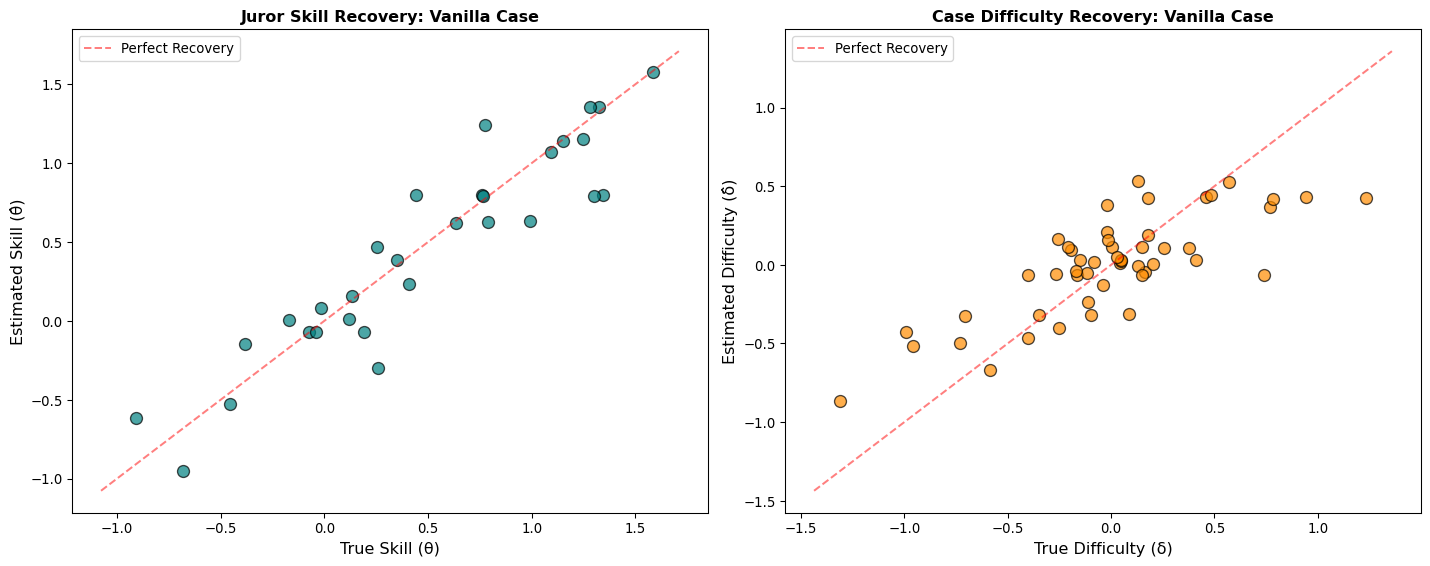

In [23]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_vanilla.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_vanilla.posterior['sigma_delta'].mean():.3f}")
plot_parameter_recovery(idata_vanilla, t_theta, t_delta, "Vanilla Case");

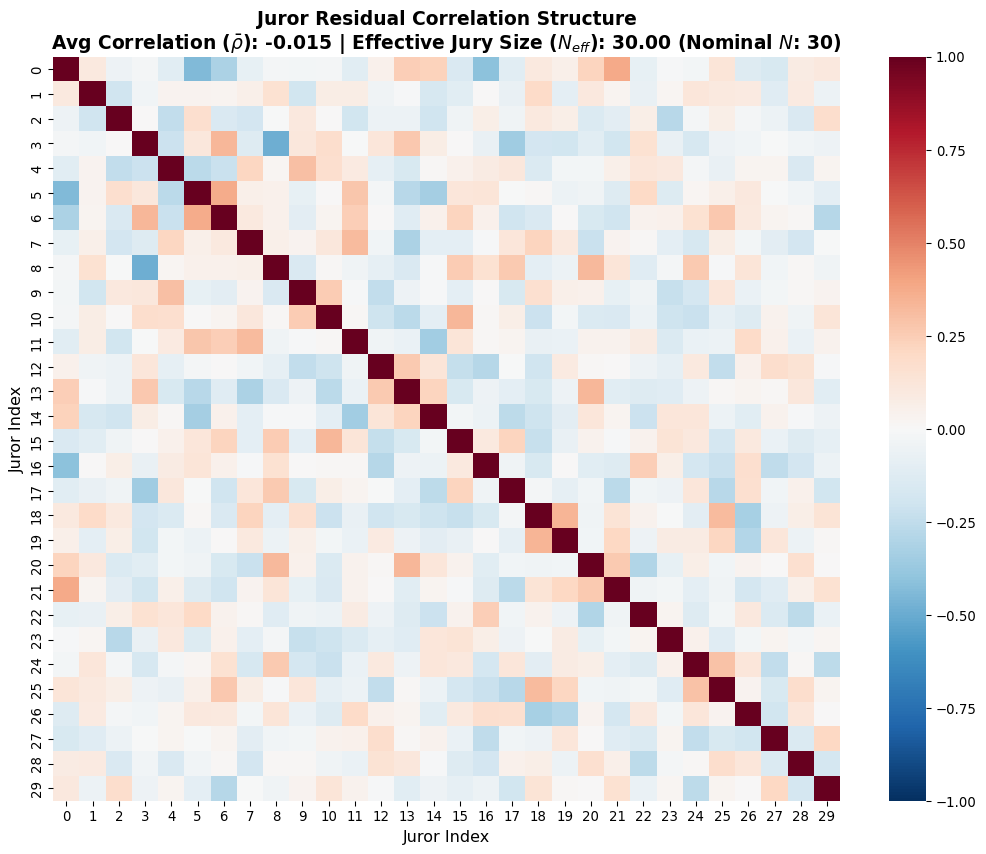

In [24]:
results_vanilla = compute_majority_accuracy_simple(
    idata_vanilla, truth_vanilla, JURY_SIZES, n_samples=500
)

plot_residual_correlation(idata_vanilla, votes_vanilla, truth_vanilla);

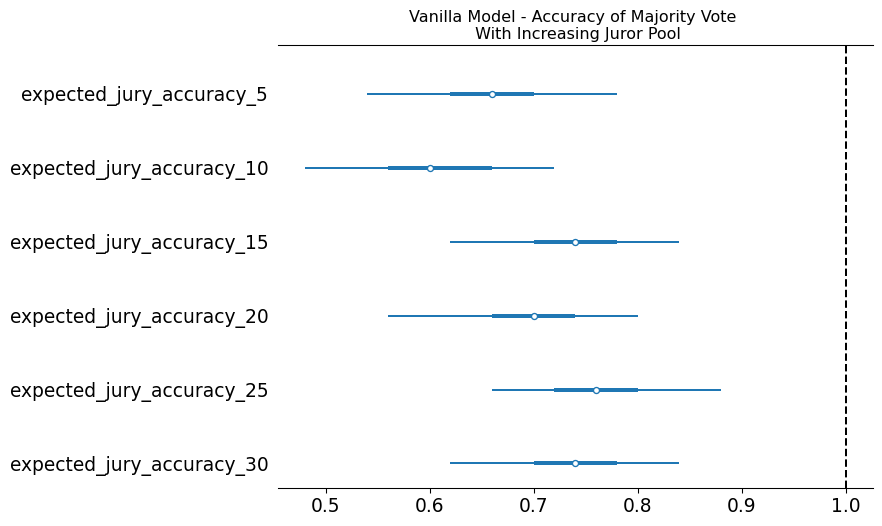

In [25]:
ax = az.plot_forest(idata_vanilla, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Vanilla Model - Accuracy of Majority Vote \n With Increasing Juror Pool");


### The Block IRT model: Skill Difference, Difficulty and Block effects



Estimated parameters:
  σ_θ: 0.282
  σ_δ: 2.043
  σ_block: 2.943


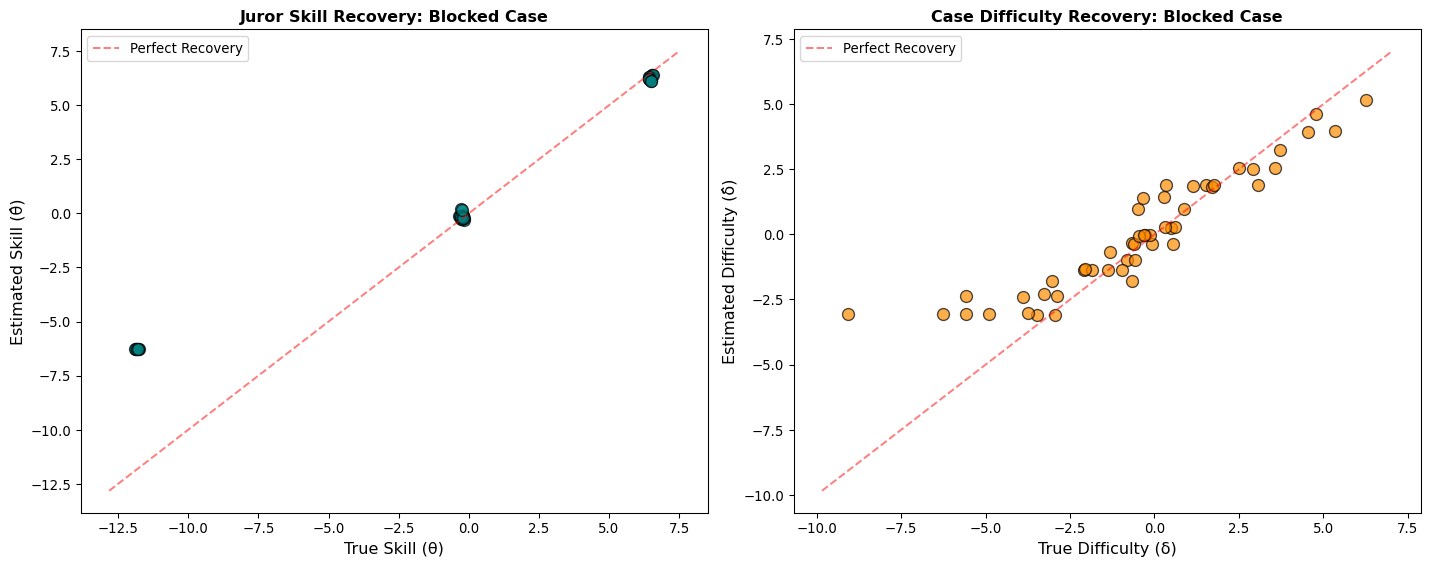

In [26]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_blocked.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_blocked.posterior['sigma_delta'].mean():.3f}")
print(f"  σ_block: {idata_blocked.posterior['sigma_block'].mean():.3f}")

plot_parameter_recovery(idata_blocked, t_theta_blocked, t_delta_blocked, "Blocked Case");



Computing accuracy by jury size...


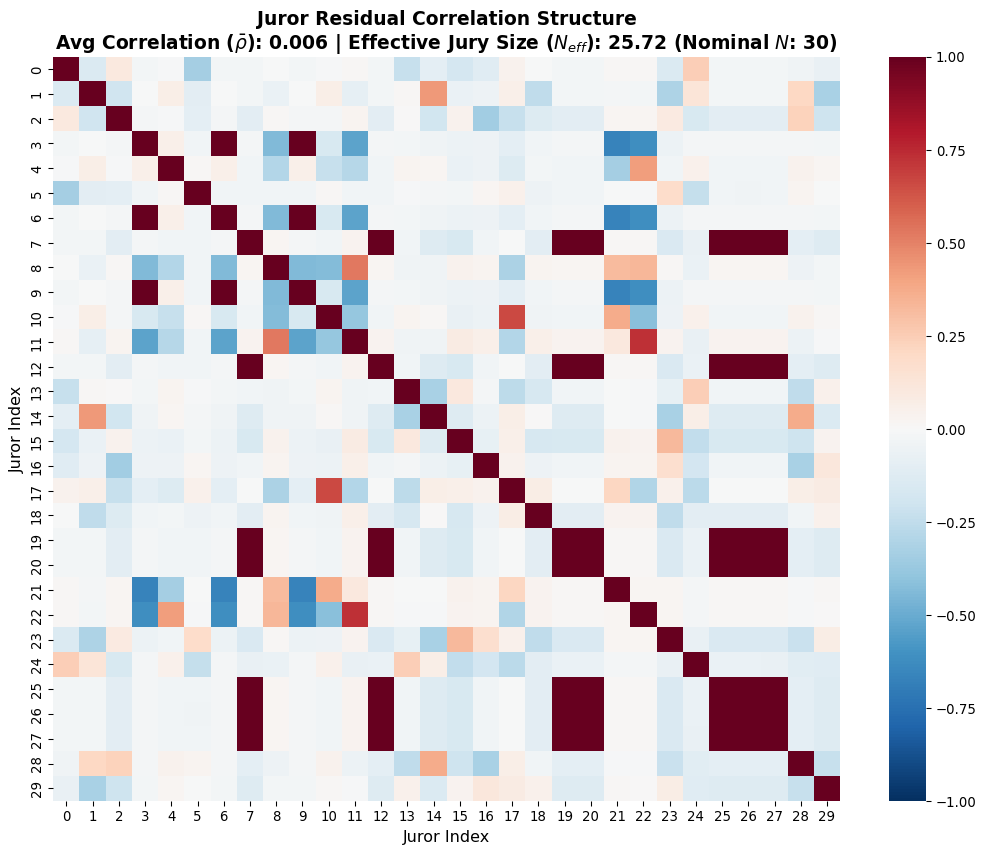

In [27]:
print("\nComputing accuracy by jury size...")
results_blocked = compute_majority_accuracy_simple(
    idata_blocked, truth_blocked, JURY_SIZES, n_samples=500
)
plot_residual_correlation(idata_blocked, votes_blocked, truth_blocked);

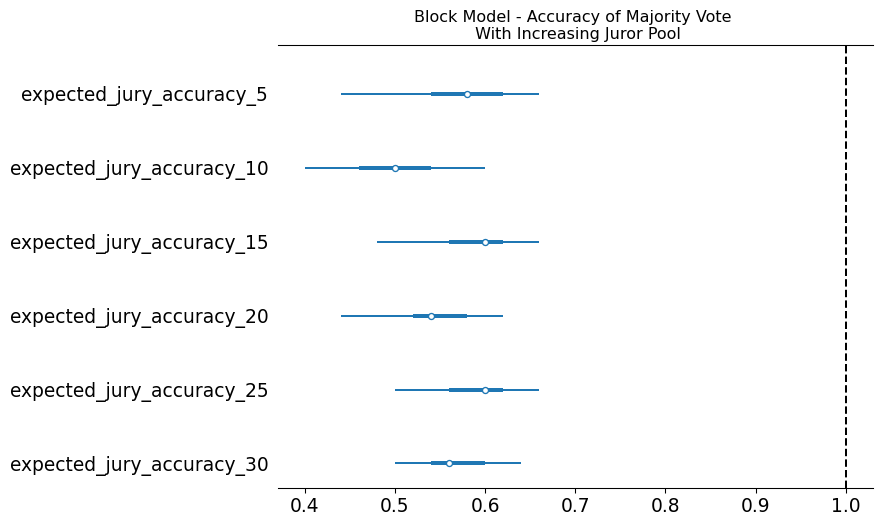

In [28]:
ax = az.plot_forest(idata_blocked, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Block Model - Accuracy of Majority Vote \n With Increasing Juror Pool");

### The Full IRT model: Difference, Difficulty, Blocks and Hetereogenous Noise



Estimated parameters:
  σ_θ: 0.171
  σ_δ: 3.124
  σ_block: 1.880
  τ: 3.167


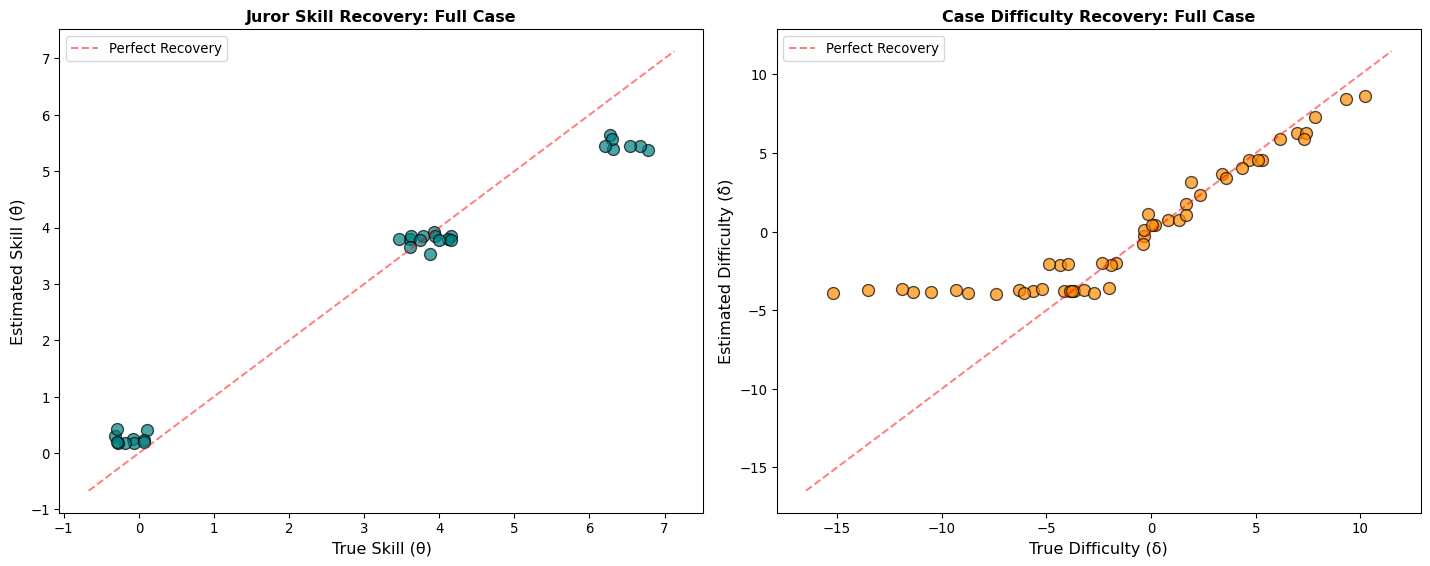

In [29]:
print(f"\nEstimated parameters:")
print(f"  σ_θ: {idata_full.posterior['sigma_theta'].mean():.3f}")
print(f"  σ_δ: {idata_full.posterior['sigma_delta'].mean():.3f}")
print(f"  σ_block: {idata_full.posterior['sigma_block'].mean():.3f}")
print(f"  τ: {idata_full.posterior['tau'].mean():.3f}")

plot_parameter_recovery(idata_full, t_theta_full, t_delta_full, "Full Case");


Computing accuracy by jury size...


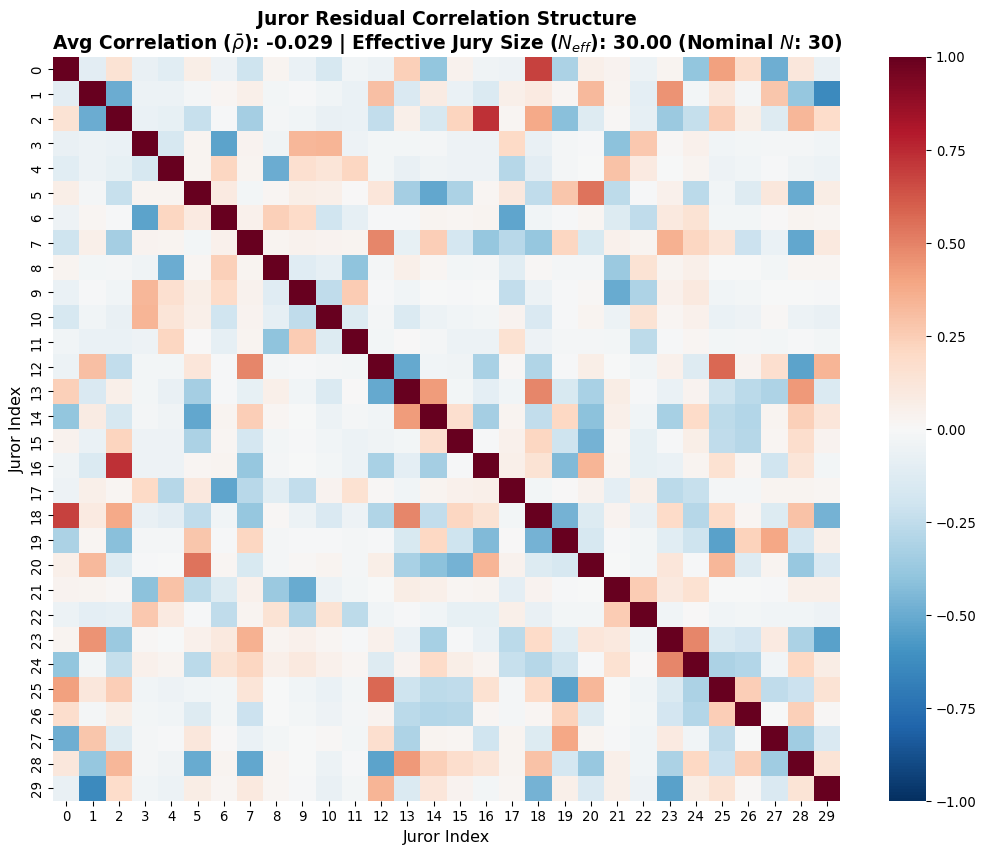

In [30]:
print("\nComputing accuracy by jury size...")
results_full = compute_majority_accuracy_simple(
    idata_full, truth_full, JURY_SIZES, n_samples=500
)

plot_residual_correlation(idata_full, votes_full, truth_full)

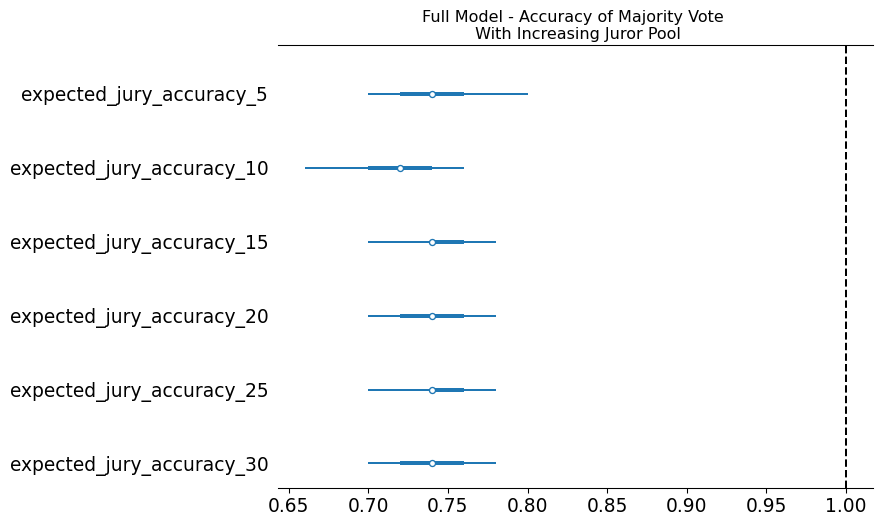

In [31]:
ax = az.plot_forest(idata_full, var_names=['expected_jury_accuracy_5', 'expected_jury_accuracy_10', 'expected_jury_accuracy_15', 'expected_jury_accuracy_20', 'expected_jury_accuracy_25' ,'expected_jury_accuracy_30'], combined=True, figsize=(8, 6));
ax[0].axvline(1, linestyle='--', color='k')
ax[0].set_title("Full Model - Accuracy of Majority Vote \n With Increasing Juror Pool");

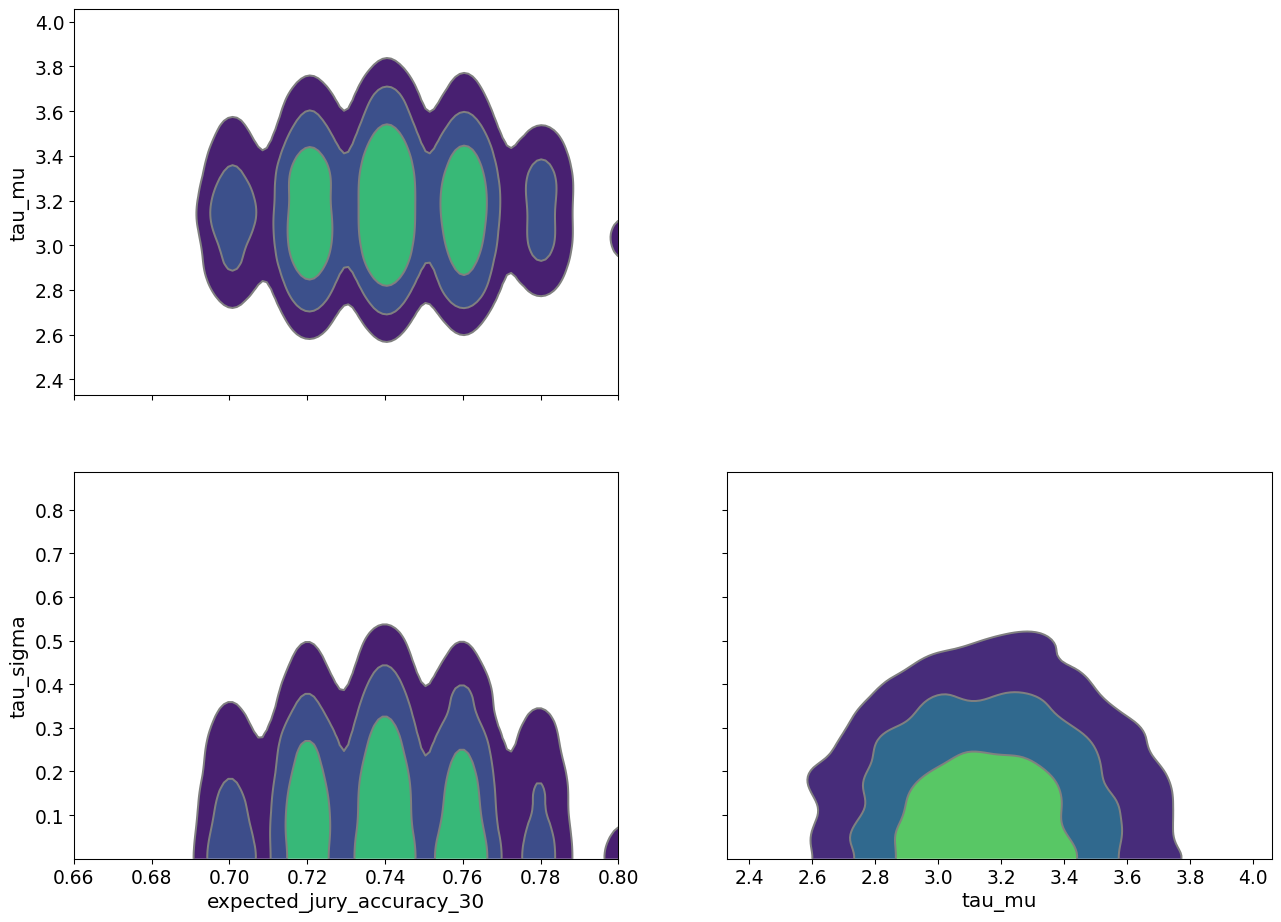

In [32]:
az.plot_pair(idata_full, var_names=['expected_jury_accuracy_30', 'tau_mu', 'tau_sigma'], kind='kde');

### Comparing the IRT models: Rate of Learning


In [33]:
results_dict = {
        'vanilla': results_vanilla,
        'blocked': results_blocked,
        'full': results_full
    }
    
print_accuracy_table(results_dict, JURY_SIZES)



DETAILED ACCURACY COMPARISON

VANILLA:
  Size  3: 0.640 [0.520, 0.760]
  Size  5: 0.660 [0.540, 0.760]
  Size  7: 0.680 [0.580, 0.800]
  Size 10: 0.720 [0.600, 0.820]
  Size 15: 0.720 [0.640, 0.840]
  Size 20: 0.760 [0.640, 0.860]
  Size 30: 0.780 [0.680, 0.880]

BLOCKED:
  Size  3: 0.580 [0.480, 0.660]
  Size  5: 0.580 [0.480, 0.660]
  Size  7: 0.580 [0.500, 0.660]
  Size 10: 0.580 [0.520, 0.680]
  Size 15: 0.580 [0.520, 0.660]
  Size 20: 0.600 [0.520, 0.660]
  Size 30: 0.580 [0.540, 0.640]

FULL:
  Size  3: 0.740 [0.680, 0.800]
  Size  5: 0.740 [0.680, 0.800]
  Size  7: 0.740 [0.700, 0.800]
  Size 10: 0.760 [0.700, 0.800]
  Size 15: 0.740 [0.720, 0.780]
  Size 20: 0.740 [0.720, 0.780]
  Size 30: 0.740 [0.720, 0.780]

IMPROVEMENT FROM SIZE 3 → 15
vanilla : 0.640 → 0.720 (Δ = +0.080, +12.5%)
blocked : 0.580 → 0.580 (Δ = +0.000, +0.0%)
full    : 0.740 → 0.740 (Δ = +0.000, +0.0%)


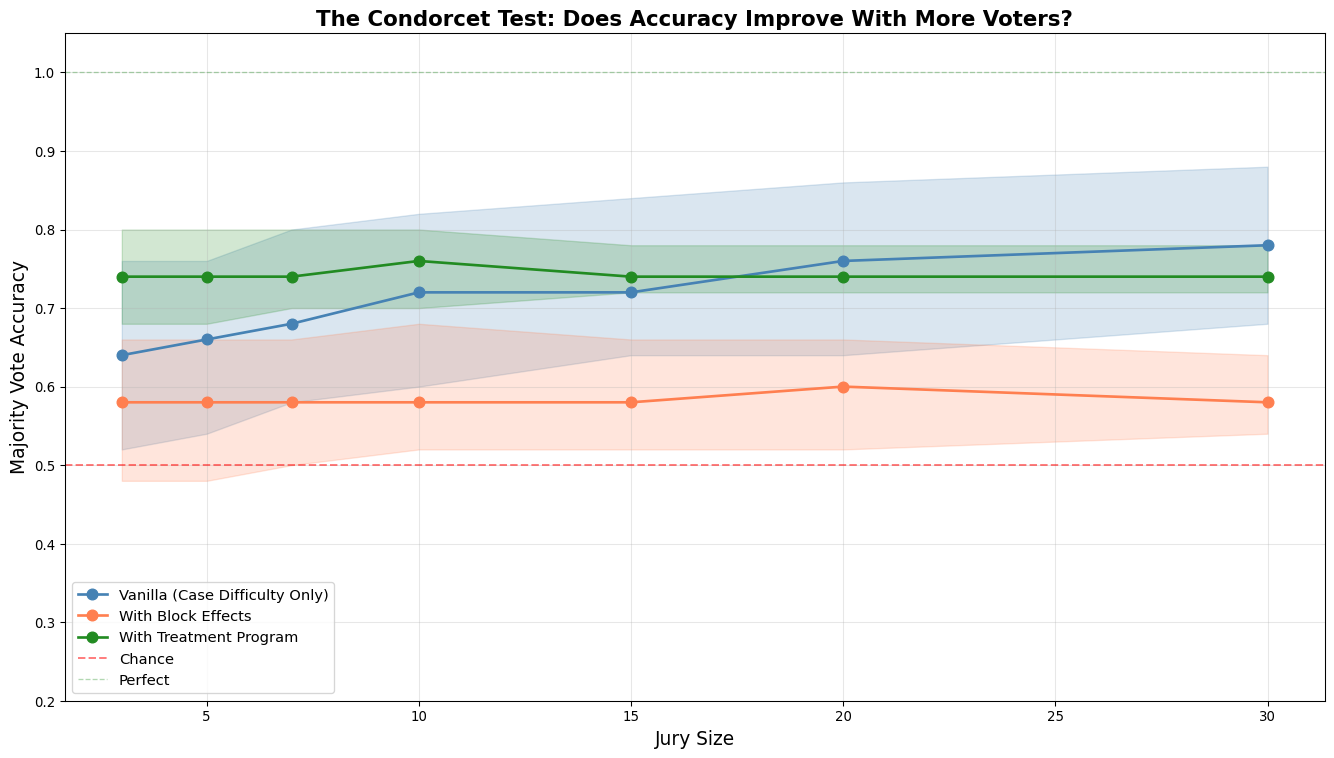

In [34]:
fig, ax = plot_accuracy_comparison(results_dict, JURY_SIZES)
plt.show()


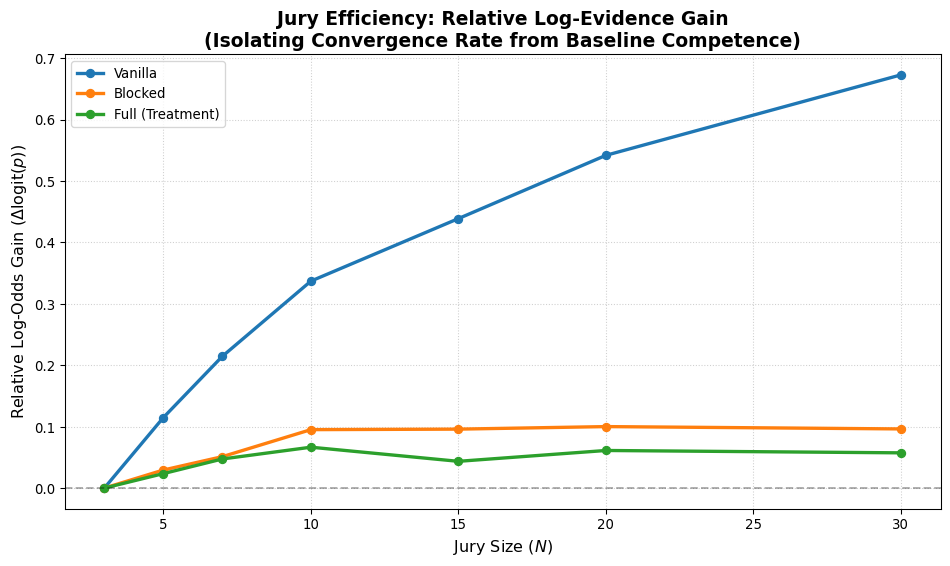

In [35]:
accuracy_dict = {
"Vanilla": [results_vanilla[size].mean() for size in JURY_SIZES],
"Blocked": [results_blocked[size].mean() for size in JURY_SIZES],
"Full (Treatment)": [results_full[size].mean() for size in JURY_SIZES]
}

# Now call the efficiency plotter
plot_condorcet_efficiency(JURY_SIZES, accuracy_dict);


We've seen here that the vanilla IRT implementation seems to exhibit convergence to accuracy expected of majority vote with increasing sets of jurors. The block model characterising group-think drives down the expected accuracy profile and the increases due to extra voters in the pool is much less pronounced that in the vanilla case. Finally, we've seen a model with expertise driven block effects that dominate our treatment intervention. The expected juror accuracy is insensitive to any degree of treatment effect because accuracy is strongly driven by the block effects in the model. 


#### The Legibility Trap: Redux
Recall that investors demand "alignment" and "standardization". They want unified KPI systems, "Culture fit"-hiring and best-practices adoption, Common Tooling. These forces push us towards organisations towards consolidation of shared incentives, methods and cognitive practices. Not only can corporate values supplant your individual perspective, they do so at scale. Every legibility-seeking practice is a block-creating mechanism. By making the organization more "readable" to outsiders, you create the very correlations that break collective intelligence.

#### The Treatment Paradox
We've cheated slightly. In our model, we've modelled the treatment and tried to attribute heterogenous responses that would help explain the voting outcome. However, we never encoded a treatment effect in the data generating process, so there was nothing to recover. Instead of a structural parameter the `tau_mu` parameter is better seen as a sensitivity parameter. We've allowed it to be weakly identified and have the model partial out any remaining influence to the treatment. The fact that it appears to have neglible effect in this case, stems from the observation that group effects sufficiently explain the outcomes. 

But in real cases this is common - group effects are persistent. Interventions are fleeting. One useful example is the pattern of "red-teaming" in software development. Before a major decision, you randomly assign people from each block to argue against their block's default position. This intervention creates divergent pressure. It doesn't eliminate block membership. Engineers remain engineers, but it forces block members to engage with perspectives that directly challenge their shared frameworks. The treatment pulls against block effects. Or so goes the theory.

## The Push and Pull: Indepence and Conformity

We've now seen two opposing forces at work in organizational decision-making:

**The Pull Toward Legibility (Block Effects)**: Shared training, common frameworks, aligned incentives. These create β-blocks—groups who think alike not because they're incompetent, but because they've been optimized for coherence. This is the gravitational force that makes organizations manageable but epistemically fragile.

**The Push Toward Independence (Treatment Effects)**: Interventions designed to break people out of their default frameworks. Red-teaming exercises, devil's advocate assignments, cross-functional rotation, deliberately soliciting dissent. These are organizational attempts to restore the independence that the Condorcet theorem requires.

Our final model formalizes this tension. Block effects (β) pull jurors toward correlated errors. Treatment effects (τ) push them back toward independence. The question is whether deliberate intervention can overcome structural gravity—or whether the legibility trap is too strong to escape.

We fit two versions of the model against the same blocked data:

**Model 1: Natural State (Z = 0 for all jurors)**
This is the organization as it exists: blocks have formed through natural processes (hiring, training, cultural evolution), and no deliberate effort is made to break people out of their silos. All variance in voting patterns must be explained by individual skill, block membership, and case difficulty.

**Model 2: Intervention State (Z = 1 for all jurors)**
This represents an organization that has implemented a comprehensive independence-restoration program. Examples might include:

- **Red-teaming**: Before voting, randomly assign people to argue against their block's default position

- **Rotation**: Temporarily embed engineers in sales, finance in product

- **Structured dissent**: Require each block to produce an internal critic before voting

- **Anonymous voting**: Remove social pressure to conform to block consensus

The treatment indicator $Z_j = 1$ tells the model: "This juror has been subjected to an intervention designed to reduce their dependence on block-default thinking."
The question: Can such interventions meaningfully push against the legibility demand? Or does the correlation persist despite our best efforts?

### What the Model Tells Us About Organizational Intervention

The forest plot reveals something uncomfortable: when we "turn on" treatment (Z = 1), the model doesn't conclude that block effects have weakened. Instead, it concludes that block effects must be *even stronger* than we thought.

Why? Because the voting patterns remain stubbornly correlated despite the presumed intervention. The Bayesian engine reasons backwards: "If treatment is supposed to push people toward independence, but I still see strong correlation in the data, then either (a) treatment doesn't work, or (b) the underlying block effects are so powerful that even treated jurors remain influenced."

The model chooses interpretation (b), allocating *more* variance to σ_block in the treatment model. This is the statistical signature of organizational inertia: interventions that look good on paper (red-teaming, rotation programs, diversity training) fail to break the fundamental correlation structure.

The treatment effect $\tau$ remains small or uncertain because the model cannot distinguish "treatment is working a little" from "blocks are just that strong." This is not a flaw in the model—it's an honest reflection of the data-generating process. If block effects are structural (shared information, shared incentives, shared training), surface-level interventions may not be enough. The model cannot tell us whether stronger interventions would work—whether, for instance, permanently breaking up blocks through forced cross-functional teams would restore independence. What it does tell us is that incremental, well-intentioned programs often aren't enough to overcome the correlation that legibility creates.

# Conclusions

A failure to properly instrumentalize values through appropriate proxy metrics hinders communication, cohesion and cooperation within and between organisations. And yet too crude an instrumentalization of value turns work from a compelling collective action project into a metric movement charade. Worse, it drives us to error and expected failure. 

The statistical breakdown of the Condorcet Jury Theorem is not an accident of poor corporate planning; it is the inevitable result of a fundamental tension in cooperative work. We are witnessing a persistent tug-of-war between two opposing gravitational forces:

- The Pull for Legibility (Scott): The necessary drive to make the organization understandable to the investor, the analyst, and the leader. This force creates the "blocks," the standardized workflows, and the shared cultures that allow thousands of people to move in the same direction.

- The Push for Agency (Nguyen): The individual’s resistance to Value Capture. This is the drive to maintain a unique, high-fidelity perspective on reality that hasn't been flattened by a KPI or a "Core Value."

When we let the pull for Legibility dominate entirely, we risk the "Contemptible Familiarity" of the over-optimized corporation. We get a system that is easy to manage on a spreadsheet or JIRA-board but potentially epistemically compromised. In the worst case: a group of 1,000 people with the collective wisdom of one, because they have all been trained to see the world through the same lens—and thus to share the same blind spots. This is the cardinal sin of "Value Capture". We have adopted the organization's simplified map of the world as our own, and in doing so, we have destroyed our ability to help the organization see.